In [1]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import os
import time
import csv
import shelve
import pickle
from datetime import datetime

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
print(theano.config.device) 
print(theano.config.floatX) # Should be 64 bit for CPUs

np.random.seed(0)

/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7301 on context None
Mapped name None to device cuda: GRID K520 (0000:00:03.0)
/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


cuda
float32


/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency

In [3]:
from sklearn.metrics import mean_squared_error as mse

In [4]:
methods = []
train_set_size = []
num_epoch = []
RMSE = []

In [5]:
# define load data function
def load_data(test=False):
    """
    Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Important that the files are in a `data` directory
    """
    FTRAIN = 'data/training.csv'
    FTEST = 'data/test.csv'
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load dataframes

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1
    y_name = np.array(df.columns[:-1])

    if not test:  # only FTRAIN has target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y, y_name

In [6]:
# Load training set and check the shape of data set
X_train, y_train, y_name = load_data()
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [7]:
def plot_data(img, landmarks, axis):
    """
    Plot image (img), along with normalized facial keypoints (landmarks)
    """
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    axis.scatter(landmarks[0::2],
        landmarks[1::2],
        marker='o',
        c='c',
        s=40)

In [8]:
# define a function to plot some of train and test set
def plot_samples(X,y):
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(9):
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        plot_data(X[i + 21], y[i + 21], ax)

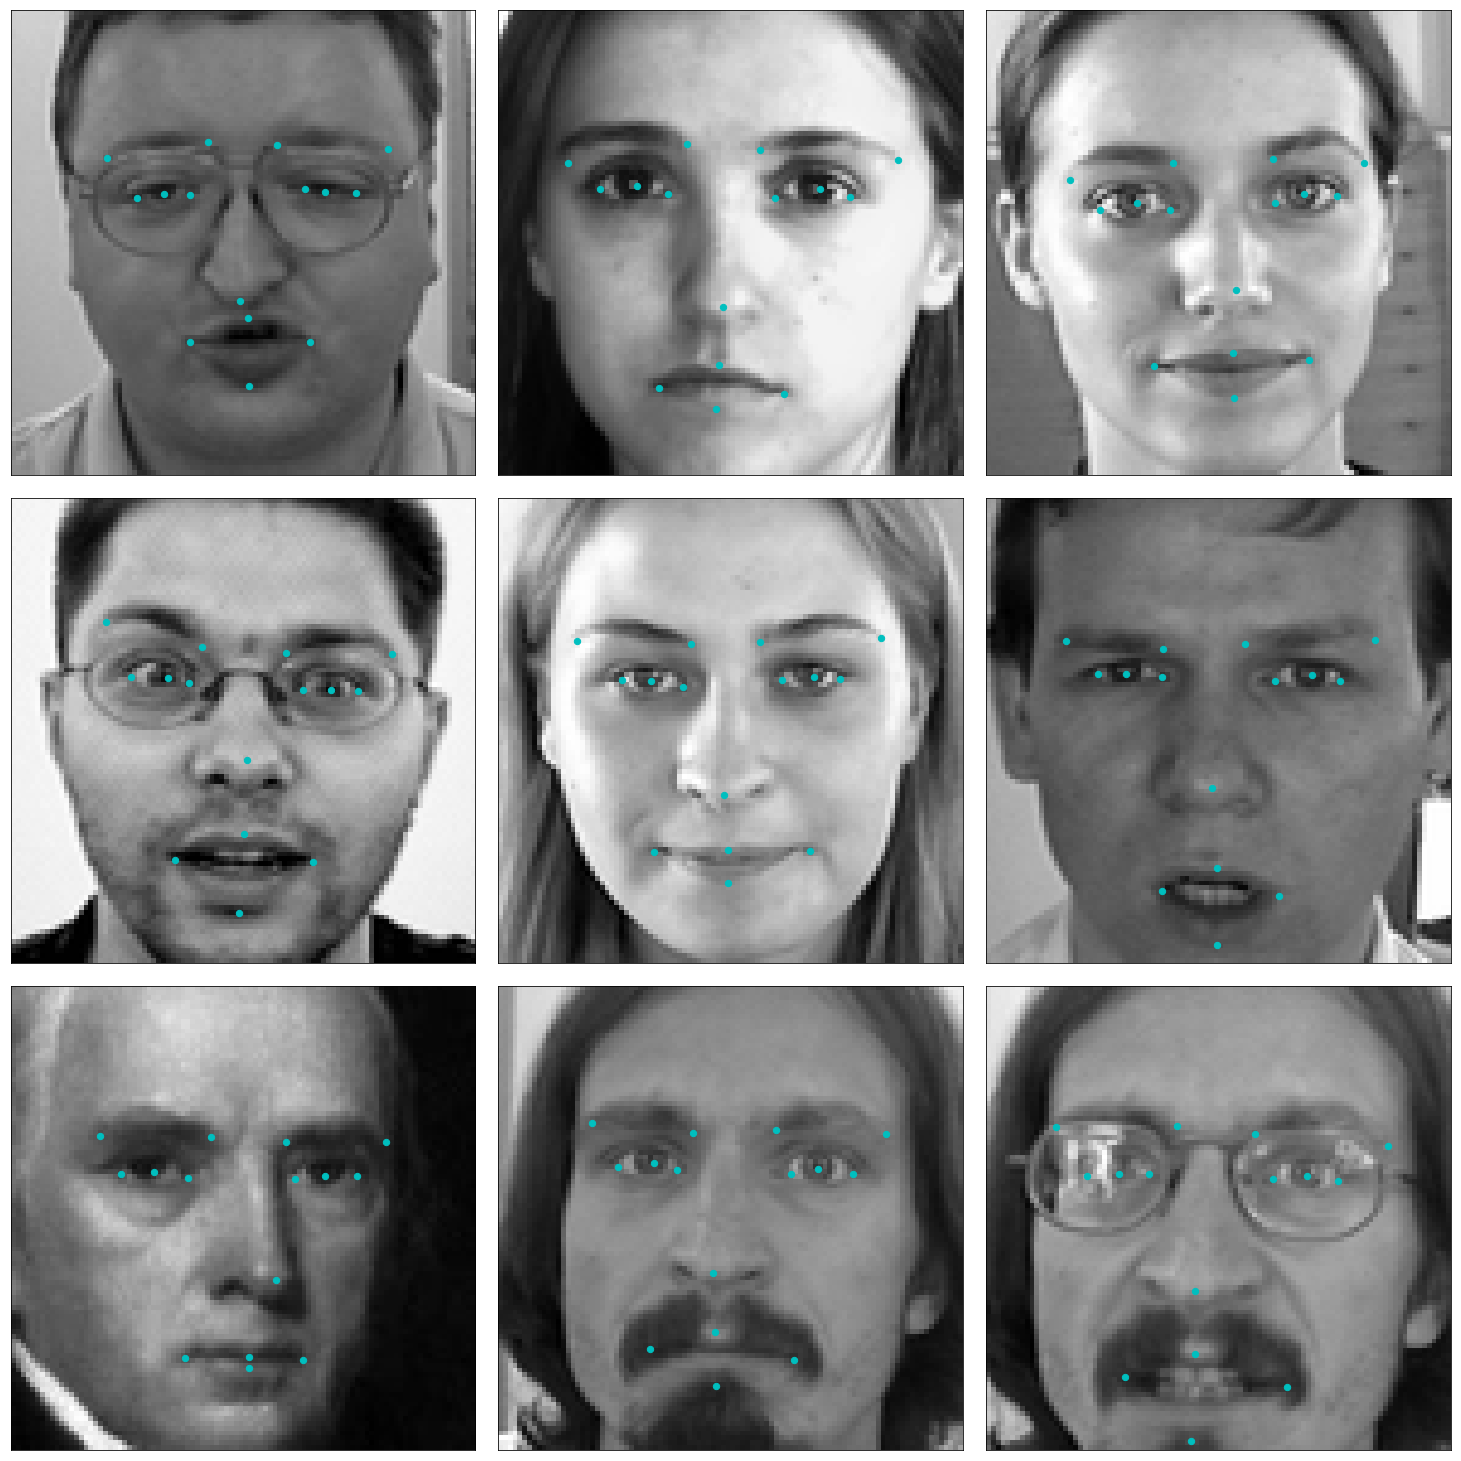

In [9]:
plot_samples(X_train,y_train)

In [10]:
# function to plot one sample image
def plot_one_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    if y is not None:
        axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

## base-line model
- First model: letNetlayer without dropout

#### Model 1: Convolutional Neural Network Using Lasagne
- Convolutional layers with reception filter: (3x3), (2x2), (2x2) respectively
- Number of layers: 32, 64, 128
- 3 subsampling layers with filter size (2x2) for each
- Use rectifier activation function for each convolutional layer

In [11]:
net_0 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [12]:
# A function load2d that wraps the previously 
# written load and does the necessary transformations is easily coded
def load2d(test=False, cols=None):
    X, y, y_name = load_data(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y, y_name

In [13]:
# function to train model
def fit_model(model, X, y):
    model = model.fit(X,y)
    return model

In [14]:
# function to predict train set with trained model
def predict_train(model,test=False):
    X, y, y_name = load_data(test=test)
    X = X.reshape(-1, 1, 96, 96)
    y_pred = model.predict(X)
    return X, y, y_pred

In [15]:
# function to predict test set with trained model
def predict_test(model, test=True):
    X,y,y_name = load_data(test=test)
    X = X.reshape(-1, 1, 96, 96)
    y_pred = model.predict(X)
    return X,y_pred

In [16]:
# function to draw loass curve for a trained model
def draw_loss_curve(model):
    train_loss = np.array([i["train_loss"] for i in model.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in model.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(0.004, 0.01)
    plt.yscale("log")
    plt.show()

In [17]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [18]:
# train model
rst_0 = fit_model(net_0, X_train_2d, y_train_2d)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.11312     0.03601    3.14106  2.22s
      2     0.01427     0.00719    1.98466  2.22s
      3     0.00717     0.00669    1.07031  2.22s
      4     0.00682     0.00645    1.05735  2.22s
      5     0.00660     0.00625    1.05656  2.22s
      6     0.00641     0.00607    1.05626  2.22s
      7     0.00624     0.00591    1.05604  2.22s
      8     0.00609     0.00577    1.05622  2.22s
      9     0.00595     0.00564    1.05632  2.22s
     10     0.00583     0.00552    1.05640  2.22s
     11     0.00572     0.00541    1.05657  2.22s
     12     0.00561

In [19]:
# calculate the RMSE value on the train set
X_train_0, y_train_0, y_train_pred_0 = predict_train(rst_0)
RMSE_rst_0 = mse(y_train_0, y_train_pred_0) ** 0.5 * 48
print('RMSE value of rst_0 : ', RMSE_rst_0)

RMSE value of rst_0 :  3.2144880503593916


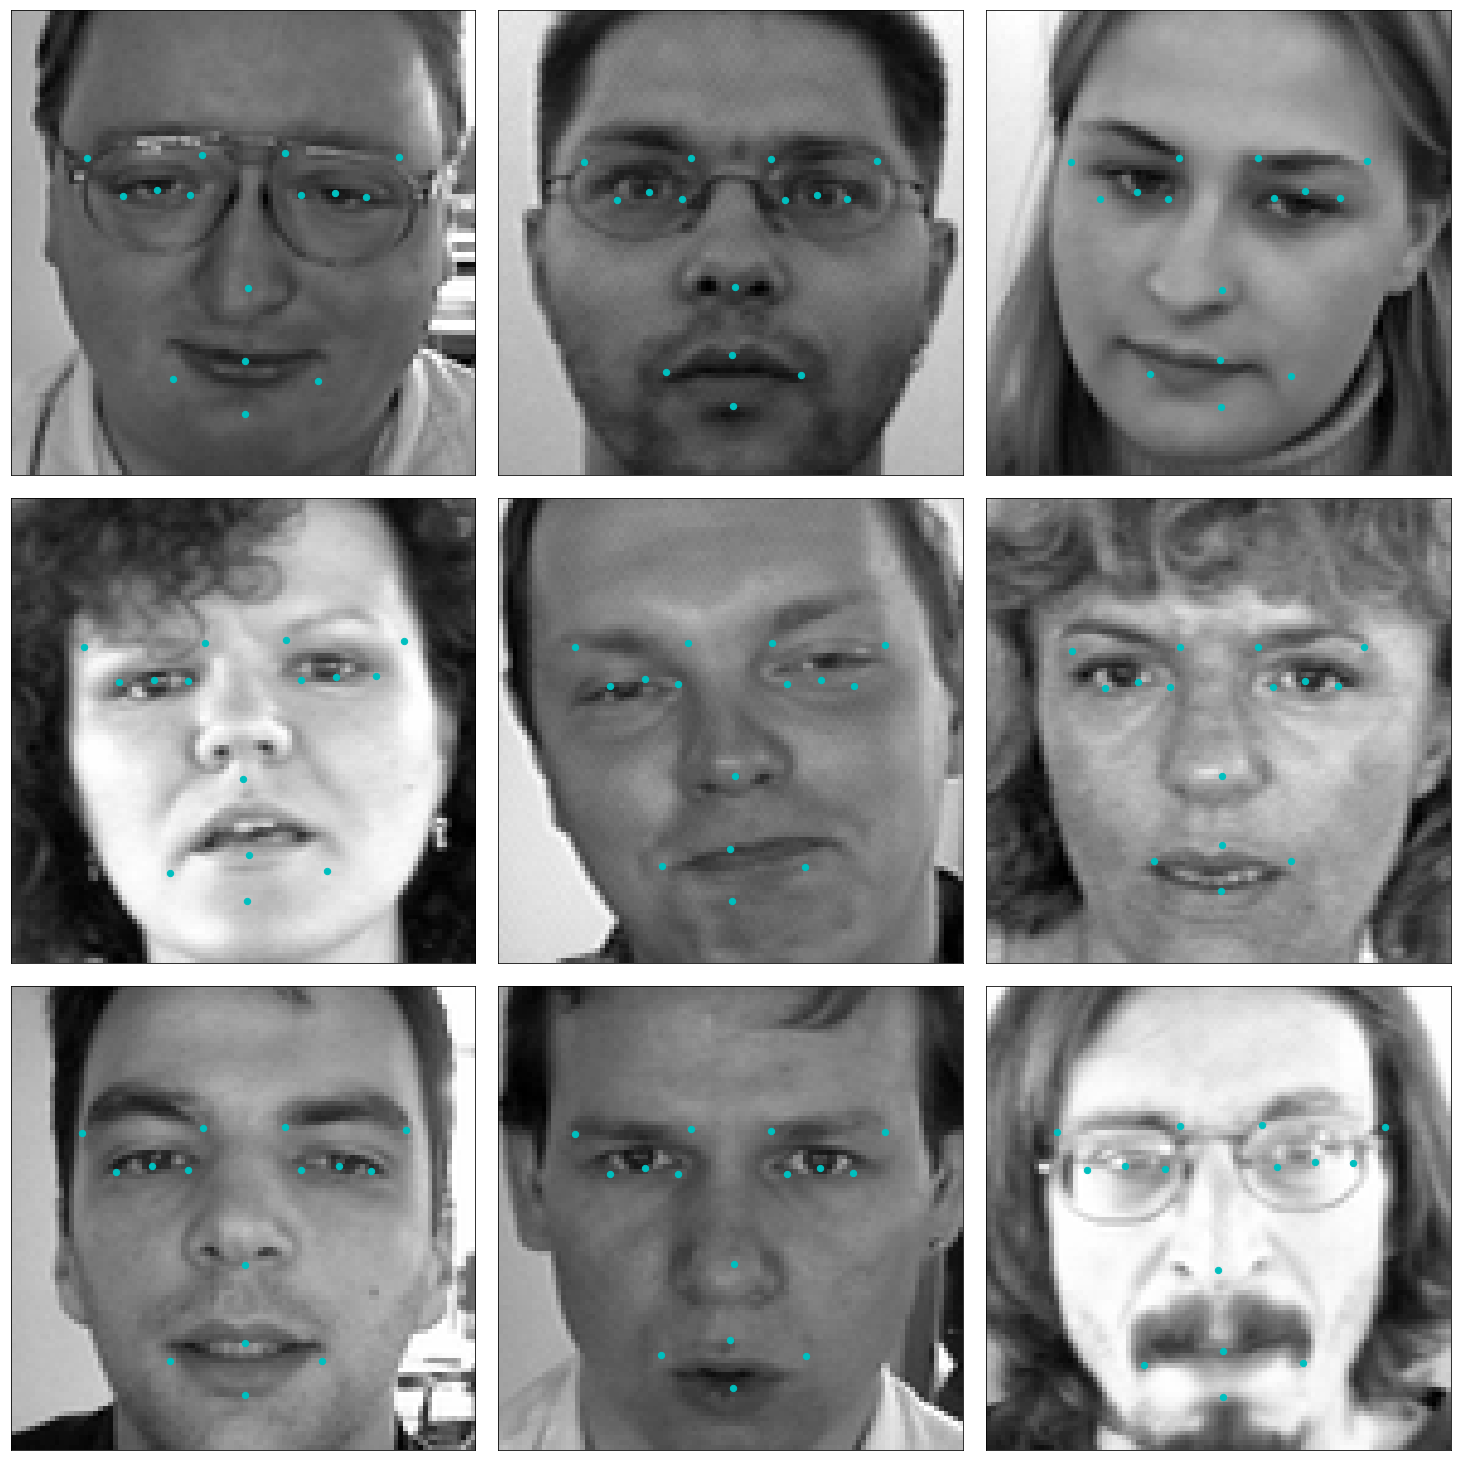

In [20]:
# predict the test set
X_test_0, y_test_pred_0 = predict_test(rst_0)
plot_samples(X_test_0,y_test_pred_0)

In [21]:
X_train_0.shape

(2140, 1, 96, 96)

In [22]:
# store the results
methods.append('Baseline')
train_set_size.append(len(X_train_0))
num_epoch.append(35)
RMSE.append(RMSE_rst_0)

In [23]:
# visualize the result
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()
layer_info(rst_0)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



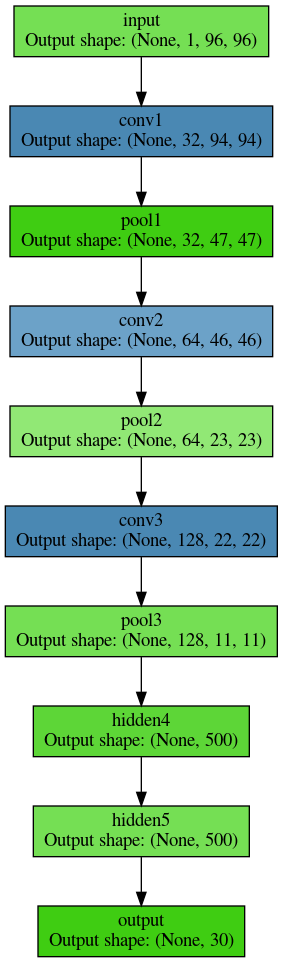

In [24]:
draw_to_notebook(rst_0)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

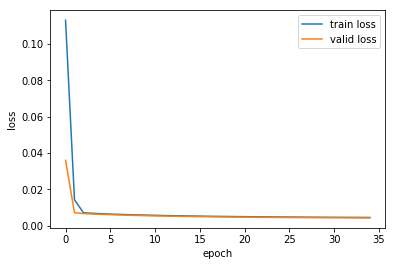

In [25]:
plot_loss(rst_0)

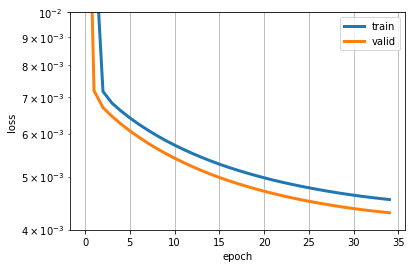

In [26]:
draw_loss_curve(rst_0)

In [27]:
# regulization with dropout layers 

In [28]:
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import os
import csv
import shelve
import pickle

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency
from sklearn.metrics import mean_squared_error as mse

In [29]:
net_1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    # 2 fully connected hidden layer
    hidden4_num_units=500,
    dropout4_p=0.5,
    hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [30]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [31]:
# train model
rst_1 = fit_model(net_1,X_train_2d, y_train_2d)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   500
 11  dropout4  500
 12  hidden5   500
 13  output    30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.07862     0.03771    2.08479  2.30s
      2     0.02623     0.03741    0.70113  2.30s
      3     0.02076     0.03453    0.60121  2.30s
      4     0.01820     0.03289    0.55354  2.30s
      5     0.01585     0.03029    0.52326  2.30s
      6     0.01407     0.02768    0.50834  2.29s
      7     0.01297     0.02573    0.50399  2.29s
      8     0.01199     0.02437    0.49206  2.29s
      9     0.01113     0.02381    0.46731  2.30s
     10     0.0

In [32]:
# predict the train set with trained model
X_train_1, y_train_1, y_train_pred_1 = predict_train(rst_1)
RMSE_rst_1 = mse(y_train_1, y_train_pred_1) ** 0.5 * 48
print('RMSE value of rst_1 : ', RMSE_rst_1)

RMSE value of rst_1 :  5.2905421251091385


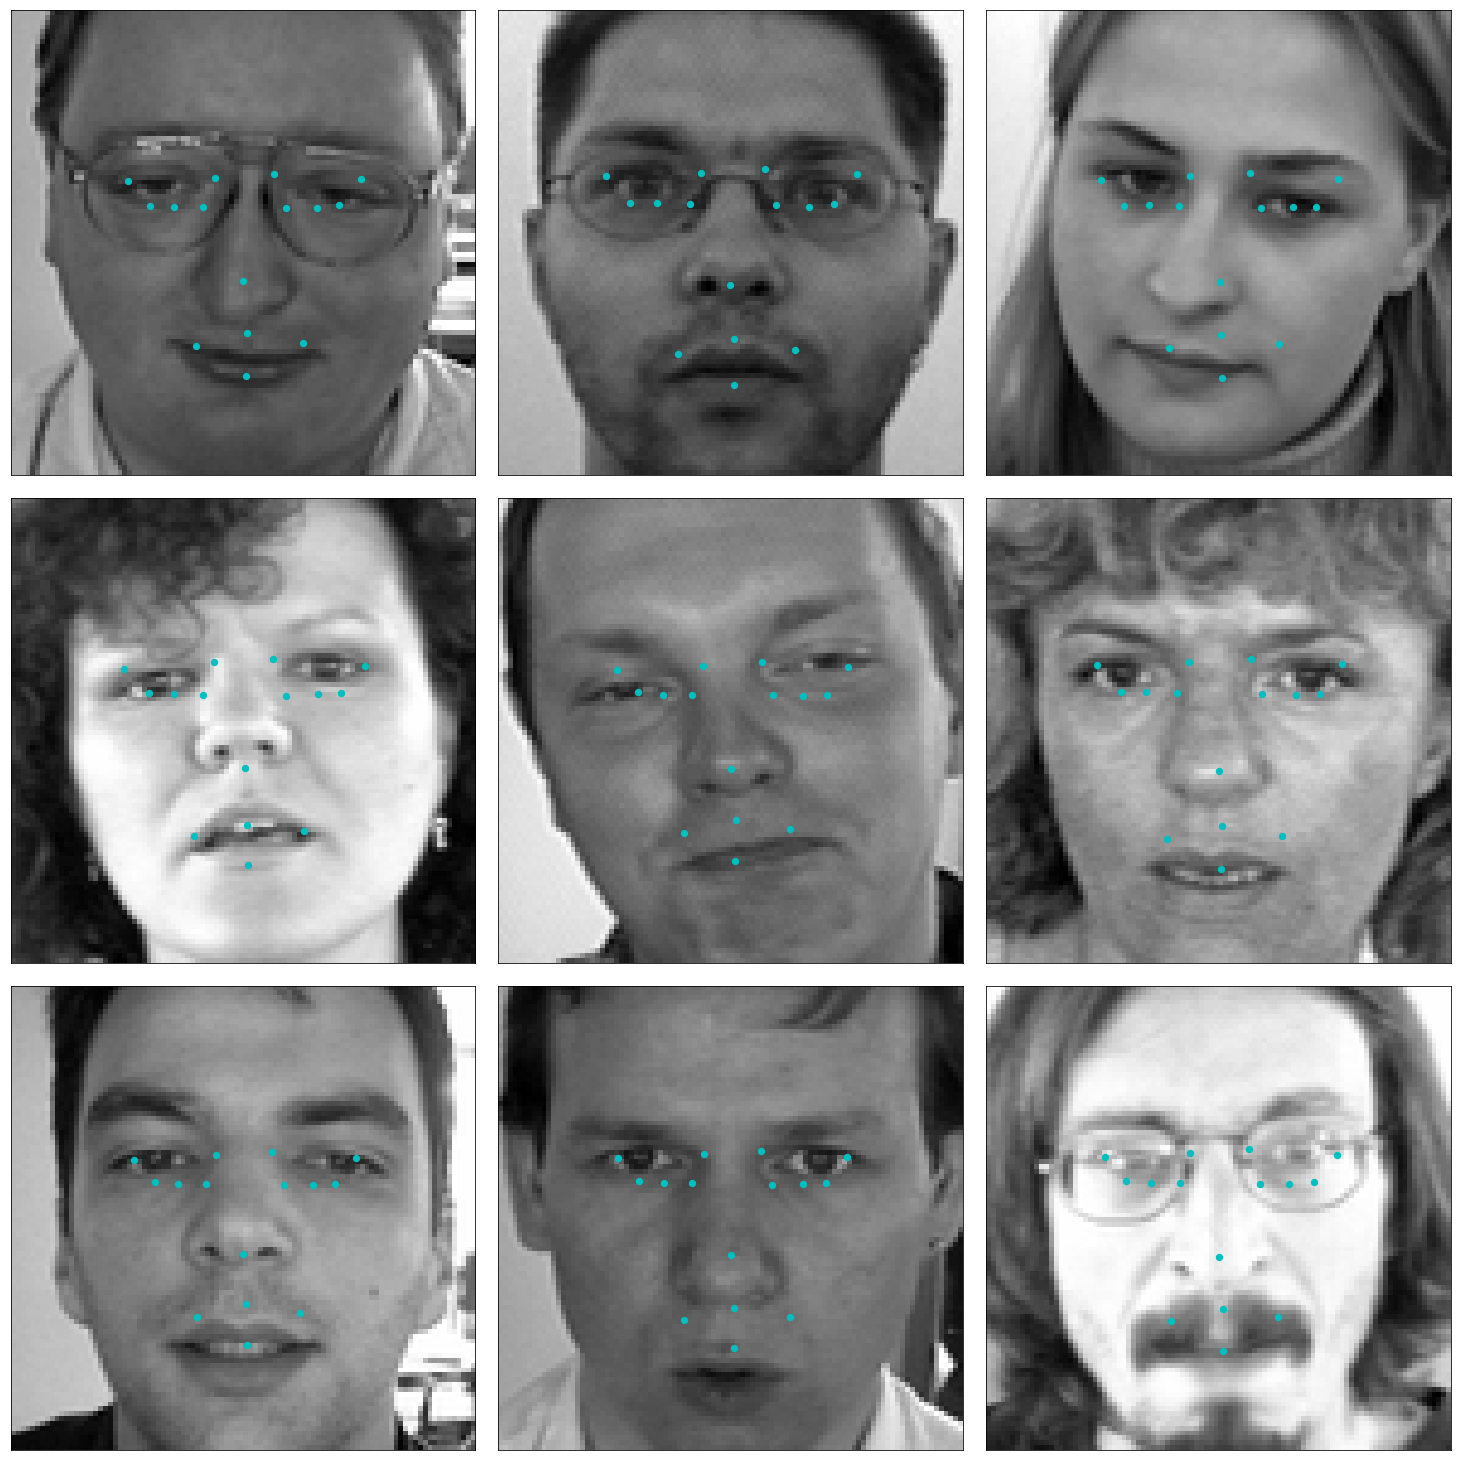

In [33]:
# predict the test set
X_test_1, y_test_pred_1 = predict_test(rst_1)
plot_samples(X_test_1,y_test_pred_1)

In [34]:
# store the results
methods.append('Regulization_with_dropout_layers')
train_set_size.append(len(X_train_1))
num_epoch.append(35)
RMSE.append(RMSE_rst_1)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   500
 11  dropout4  500
 12  hidden5   500
 13  output    30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

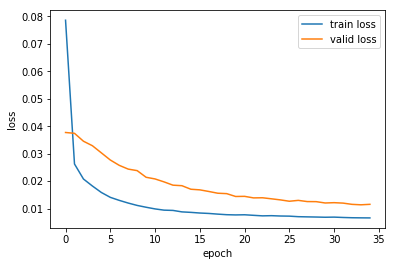

In [35]:
# print layer information
# draw loss curve
layer_info(rst_1)
draw_to_notebook(rst_1)
plot_loss(rst_1)

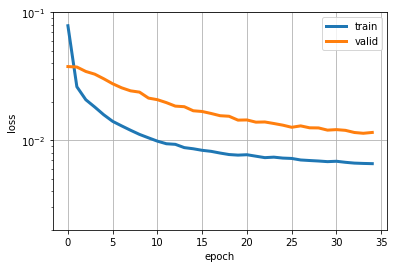

In [36]:
train_loss = np.array([i["train_loss"] for i in net_1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net_1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0.002, 0.1)
plt.yscale("log")
plt.show()

###  Improvement methods :
1. Data Augmentation
2. Model tunning

In [37]:
# Data Augmentation

## Data Augmentation1: Flipping the images horizontically
- Flip the face horizontally
- Rename x direction features by switching left and right
- To the human eye, the images look similar. Yet they look brand new to the model. Benefit: - Increases training dataset with no cos

## define horizontally flipping function
- left_eye_center_x -> right_eye_center_x
- left_eye_center_y -> right_eye_center_y
- left_eye_inner_corner_x -> right_eye_inner_corner_x
- left_eye_inner_corner_y -> right_eye_inner_corner_y
- left_eye_outer_corner_x -> right_eye_outer_corner_x
- left_eye_outer_corner_y -> right_eye_outer_corner_y
- left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
- left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
- left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
- left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
- mouth_left_corner_x -> mouth_right_corner_x
- mouth_left_corner_y -> mouth_right_corner_y

In [38]:
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import os
import csv
import shelve
import pickle

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency
from sklearn.metrics import mean_squared_error as mse

In [39]:
# define horizontally flipping function
def flip_faces_horizontally(X_train_2d,y_train_2d, y_name):
    # step1: flip the impage
    X_flipped = X_train_2d[:, :, :, ::-1]  # simple slice to flip all images
    
    #step2: flip the x coordinate value
    multiplier = [-1,1]*int(y_train_2d.shape[1]/2)
    y_flip = np.multiply([multiplier,]*y_train_2d.shape[0], y_train_2d)
    
    # flip the x coordinates/column name
    y_name_flip = []
    for name in y_name:
        if 'left' in name.lower():
            y_name_flip.append(name.replace('left','right'))
        elif 'right' in name.lower():
            y_name_flip.append(name.replace('right','left'))
        else:
            y_name_flip.append(name)
    y_name_flip = np.array(y_name_flip)
    index = [np.where(y_name_flip == x)[0][0] for x in y_name]
    y_flipped = y_flip[:, index]
    
    # combine data and align with original column
    y_train_2d = np.concatenate((y_train_2d, y_flip[:, index]), axis=0)
    X_train_2d = np.concatenate((X_train_2d, X_flipped), axis=0)
    print('After merge X:%s, y:%s' %(X_train_2d.shape, y_train_2d.shape))
    return X_train_2d, y_train_2d, X_flipped, y_flipped

In [40]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [41]:
# get merged data set with orignal train and flipped 
X_train_merged, y_train_merged, X_flipped, y_flipped = flip_faces_horizontally(X_train_2d, y_train_2d, y_name)

After merge X:(4280, 1, 96, 96), y:(4280, 30)


In [42]:
# check the shape of train data set, flipped set and merged set
print('X_train shape: ', X_train_2d.shape)
print('y_train shape: ', y_train_2d.shape)
print('X_train_merge shape: ', X_train_merged.shape)
print('y_train_merge shape: ', y_train_merged.shape)
print('X_flipped shape: ', len(X_flipped))
print('y_flipped shape: ', len(y_flipped))

X_train shape:  (2140, 1, 96, 96)
y_train shape:  (2140, 30)
X_train_merge shape:  (4280, 1, 96, 96)
y_train_merge shape:  (4280, 30)
X_flipped shape:  2140
y_flipped shape:  2140


In [43]:
# function to plot two pictures before flipping and after flipping
def plot_two_for_compare_mirror(X_train_2d, X_train_merge, y_train_2d, y_train_2d_merge):
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    plot_one_sample(X_train_2d[1], y_train_2d[1], ax)
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    plot_one_sample(X_train_2d_merge[2141], y_train_2d_merge[2141], ax)
    plt.show()

In [44]:
net_01 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [45]:
# check the data type and shape of data set after fliping X_train, y_train
print('type of X_train_merged : ', type(X_train_merged))
print('X_train_merged.dtype : ', X_train_merged.dtype)
print('y_train_merged.dtype : ', y_train_merged.dtype)
# check the data type of y from float64 to float 32 for model training
y_train_merged = y_train_merged.astype('float32')
print('y_train_merged.dtype : ', y_train_merged.dtype)

type of X_train_merged :  <class 'numpy.ndarray'>
X_train_merged.dtype :  float32
y_train_merged.dtype :  float64
y_train_merged.dtype :  float32


In [46]:
rst_01 = fit_model(net_01, X_train_merged, y_train_merged)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.04639     0.00787    5.89446  4.41s
      2     0.00731     0.00713    1.02551  4.41s
      3     0.00673     0.00663    1.01502  4.41s
      4     0.00632     0.00626    1.00946  4.41s
      5     0.00600     0.00596    1.00600  4.41s
      6     0.00574     0.00572    1.00348  4.41s
      7     0.00553     0.00552    1.00172  4.41s
      8     0.00536     0.00536    1.00050  4.41s
      9     0.00521     0.00522    0.99961  4.41s
     10     0.00509     0.00510    0.99902  4.41s
     11     0.00499     0.00500    0.99852  4.41s
     12     0.00490

In [47]:
# predict the train set with trained model
X_train_01, y_train_01, y_train_pred_01 = predict_train(rst_01)
RMSE_rst_01 = mse(y_train_01, y_train_pred_01) ** 0.5 * 48
print('RMSE value of rst_01 : ', RMSE_rst_01)

RMSE value of rst_01 :  3.1948739196185683


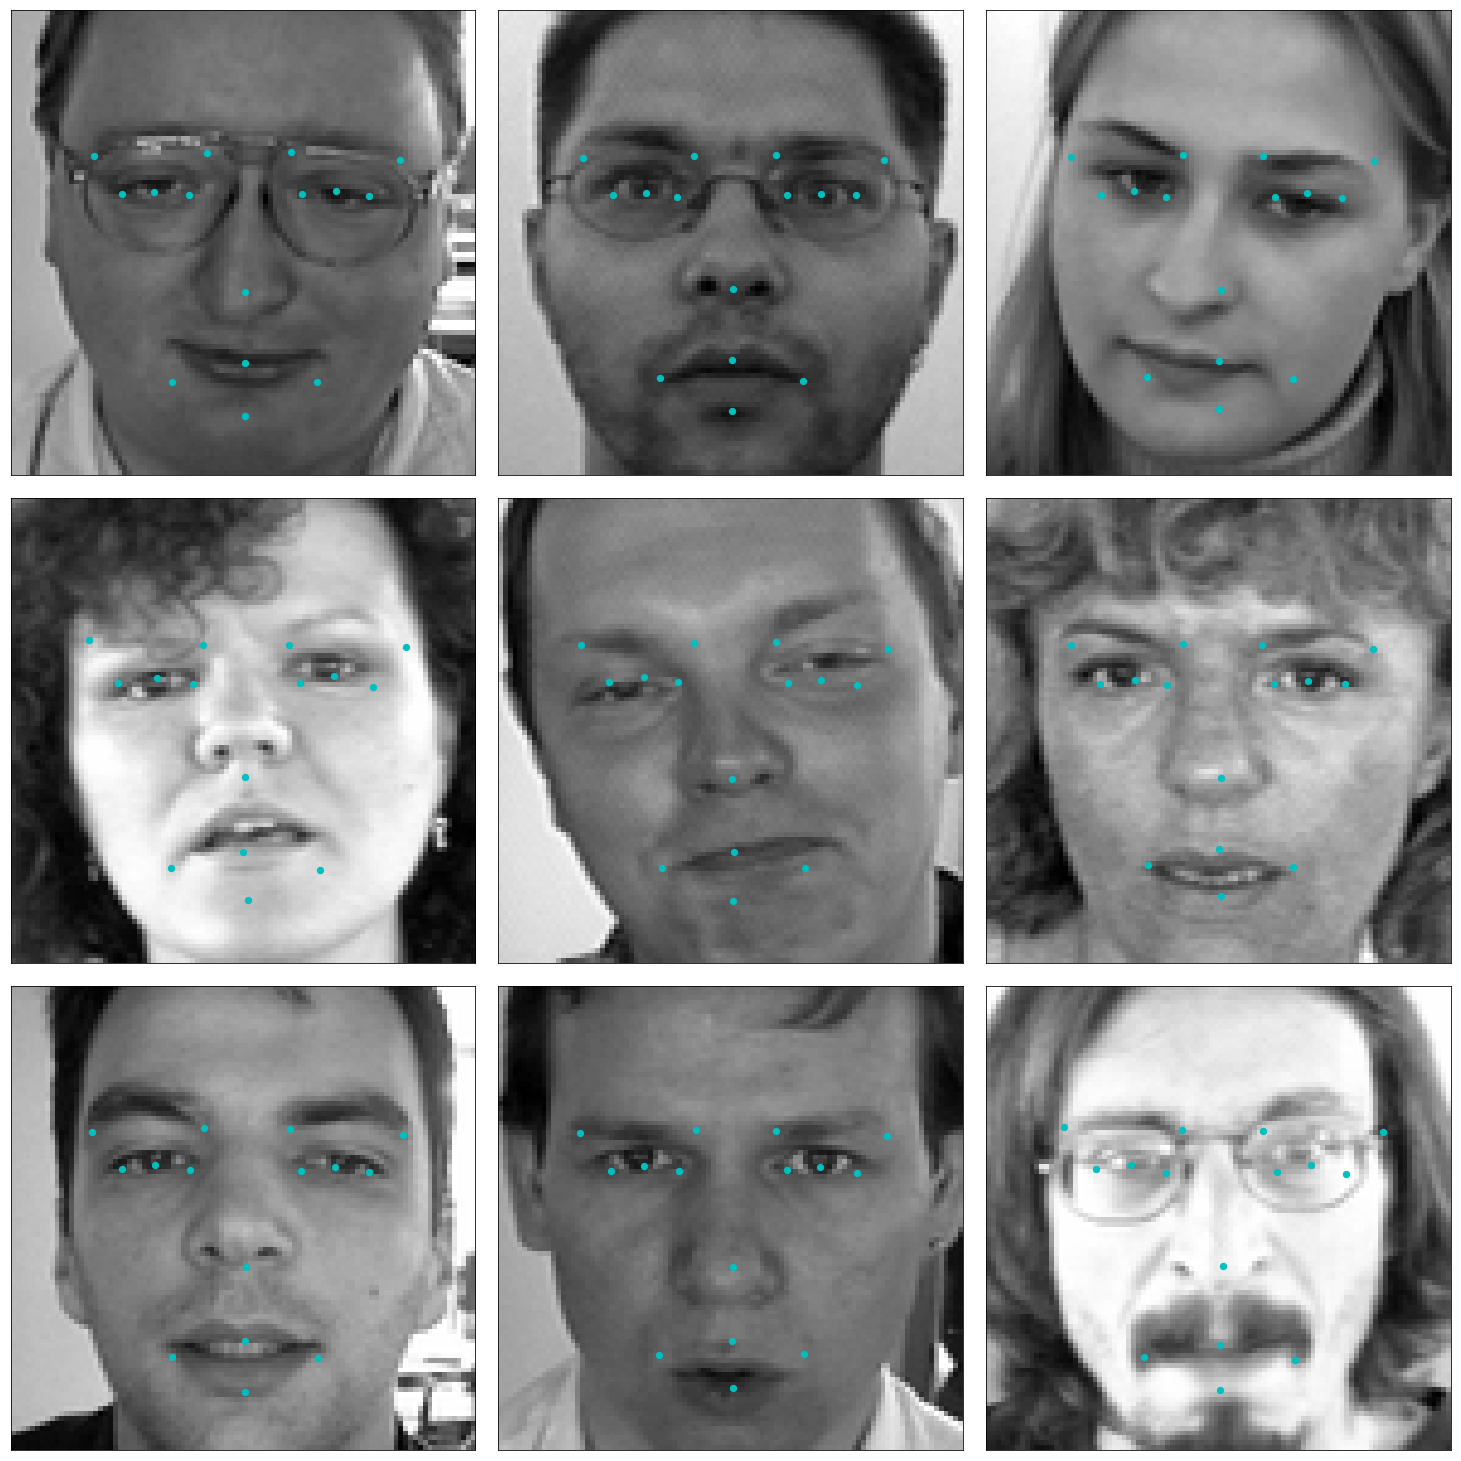

In [48]:
# predict the test set
X_test_01, y_test_pred_01 = predict_test(rst_01)
plot_samples(X_test_01,y_test_pred_01)

In [49]:
X_train_merged.shape

(4280, 1, 96, 96)

In [50]:
# store the results
methods.append('Flipping')
train_set_size.append(len(X_train_merged))
num_epoch.append(35)
RMSE.append(RMSE_rst_01)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

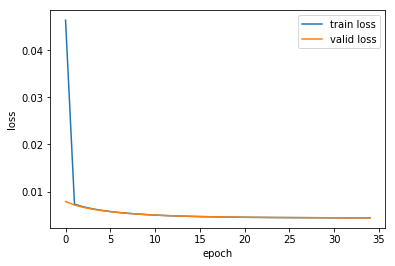

In [51]:
# print layer information
# draw loss curve
layer_info(rst_01)
draw_to_notebook(rst_01)
plot_loss(rst_01)

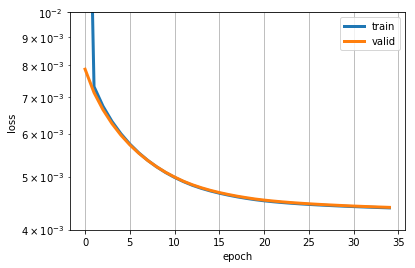

In [52]:
draw_loss_curve(rst_01)

### Data Augmentation 2 : Histogram Stretching
- $a$ and $b$ are 5 and 95 percentile of the image<>
- $l$ and $u$ are 0 and 1 respectively for the maximum range
- Histogram stretching transfers any point $p$ of the image to $p^{\prime}$ such that: $\displaystyle \frac{p-a}{b-a} = \frac{p^{\prime}-l}{u-l} $
- The transferred image is expected to have better contrast.

In [53]:
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import os
import csv
import shelve
import pickle

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency
from sklearn.metrics import mean_squared_error as mse

In [54]:
X_train_2d, y_train_2d, y_name = load2d() 

In [55]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [56]:
X_train, y_train, y_name = load_data()
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [57]:
# define a function plotting two picture 
def plot_two(image1, p1, image2, p2):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(image1,(96,96)), cmap = 'Greys_r')
    for x, y in np.reshape(p1,(int(len(p1)/2), 2)):
        plt.plot(x, y, 'r+')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(image2,(96,96)), cmap = 'Greys_r')
    for x, y in np.reshape(p2,(int(len(p2)/2), 2)):
        plt.plot(x, y, 'r+')
    plt.axis('off')

In [58]:
# histogram stretching function
def HistogramStretching(image):
#     a, b = min(image), max(image) 
    a, b = np.percentile(image, 5), np.percentile(image, 95)
    l, u = 0, 1
    const = 1.0 * (b * l - a * u) / (b - a)
    k = 1.0 * (u - l) / (b - a)
    return [k * p + const for p in image]

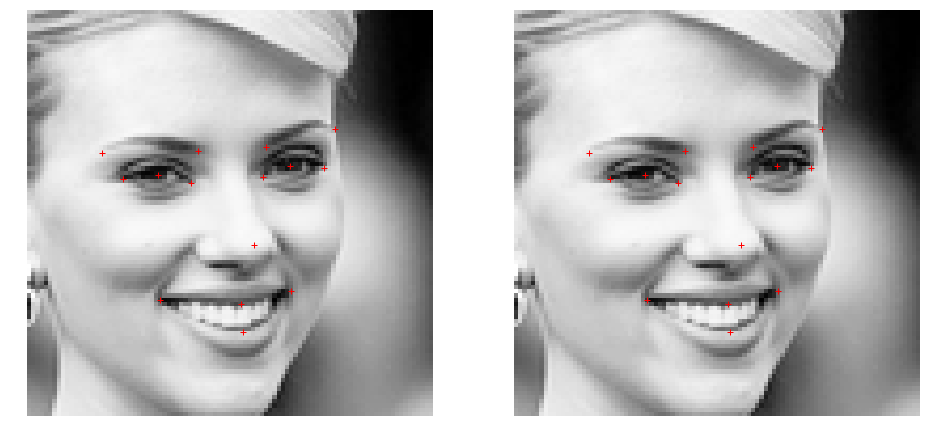

In [59]:
# plot an example
X_train_hist = [HistogramStretching(x) for x in X_train]
image1 = X_train[12]
impage2 = X_train_hist[12]
y1 = y_train[12] * 48 + 48
y2 = y_train[12] * 48 + 48
plot_two(image1, y1, impage2, y2)

In [60]:
# reshpe X_train_hist as X_train before merge
X_train_hist_arr = np.asarray(X_train_hist)
X_train_hist_arr = X_train_hist_arr.reshape(-1, 1, 96, 96)

In [61]:
# merger X_train and X_train_hist
X_train_with_hist = np.concatenate((X_train_2d, X_train_hist_arr), axis = 0)
y_train_with_hist = np.concatenate((y_train_2d, y_train), axis = 0)
print('X_train_with_hist shape : ', X_train_with_hist.shape)
print('y_train_with_hist shape : ', y_train_with_hist.shape)

X_train_with_hist shape :  (4280, 1, 96, 96)
y_train_with_hist shape :  (4280, 30)


In [62]:
net_02 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [63]:
rst_02 = fit_model(net_02, X_train_with_hist, y_train_with_hist)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.05166     0.01008    5.12430  4.41s
      2     0.00713     0.00921    0.77345  4.42s
      3     0.00665     0.00865    0.76888  4.41s
      4     0.00631     0.00820    0.76976  4.42s
      5     0.00605     0.00782    0.77284  4.42s
      6     0.00584     0.00751    0.77782  4.41s
      7     0.00567     0.00723    0.78349  4.42s
      8     0.00552     0.00700    0.78940  4.41s
      9     0.00540     0.00679    0.79569  4.41s
     10     0.00529     0.00660    0.80223  4.41s
     11     0.00520     0.00643    0.80864  4.41s
     12     0.00512

In [64]:
# predict the train set with trained model
X_train_02, y_train_02, y_train_pred_02 = predict_train(rst_02)
RMSE_rst_02 = mse(y_train_02, y_train_pred_02) ** 0.5 * 48
print('RMSE value of rst_02 : ', RMSE_rst_02)

RMSE value of rst_02 :  3.2984903545472806


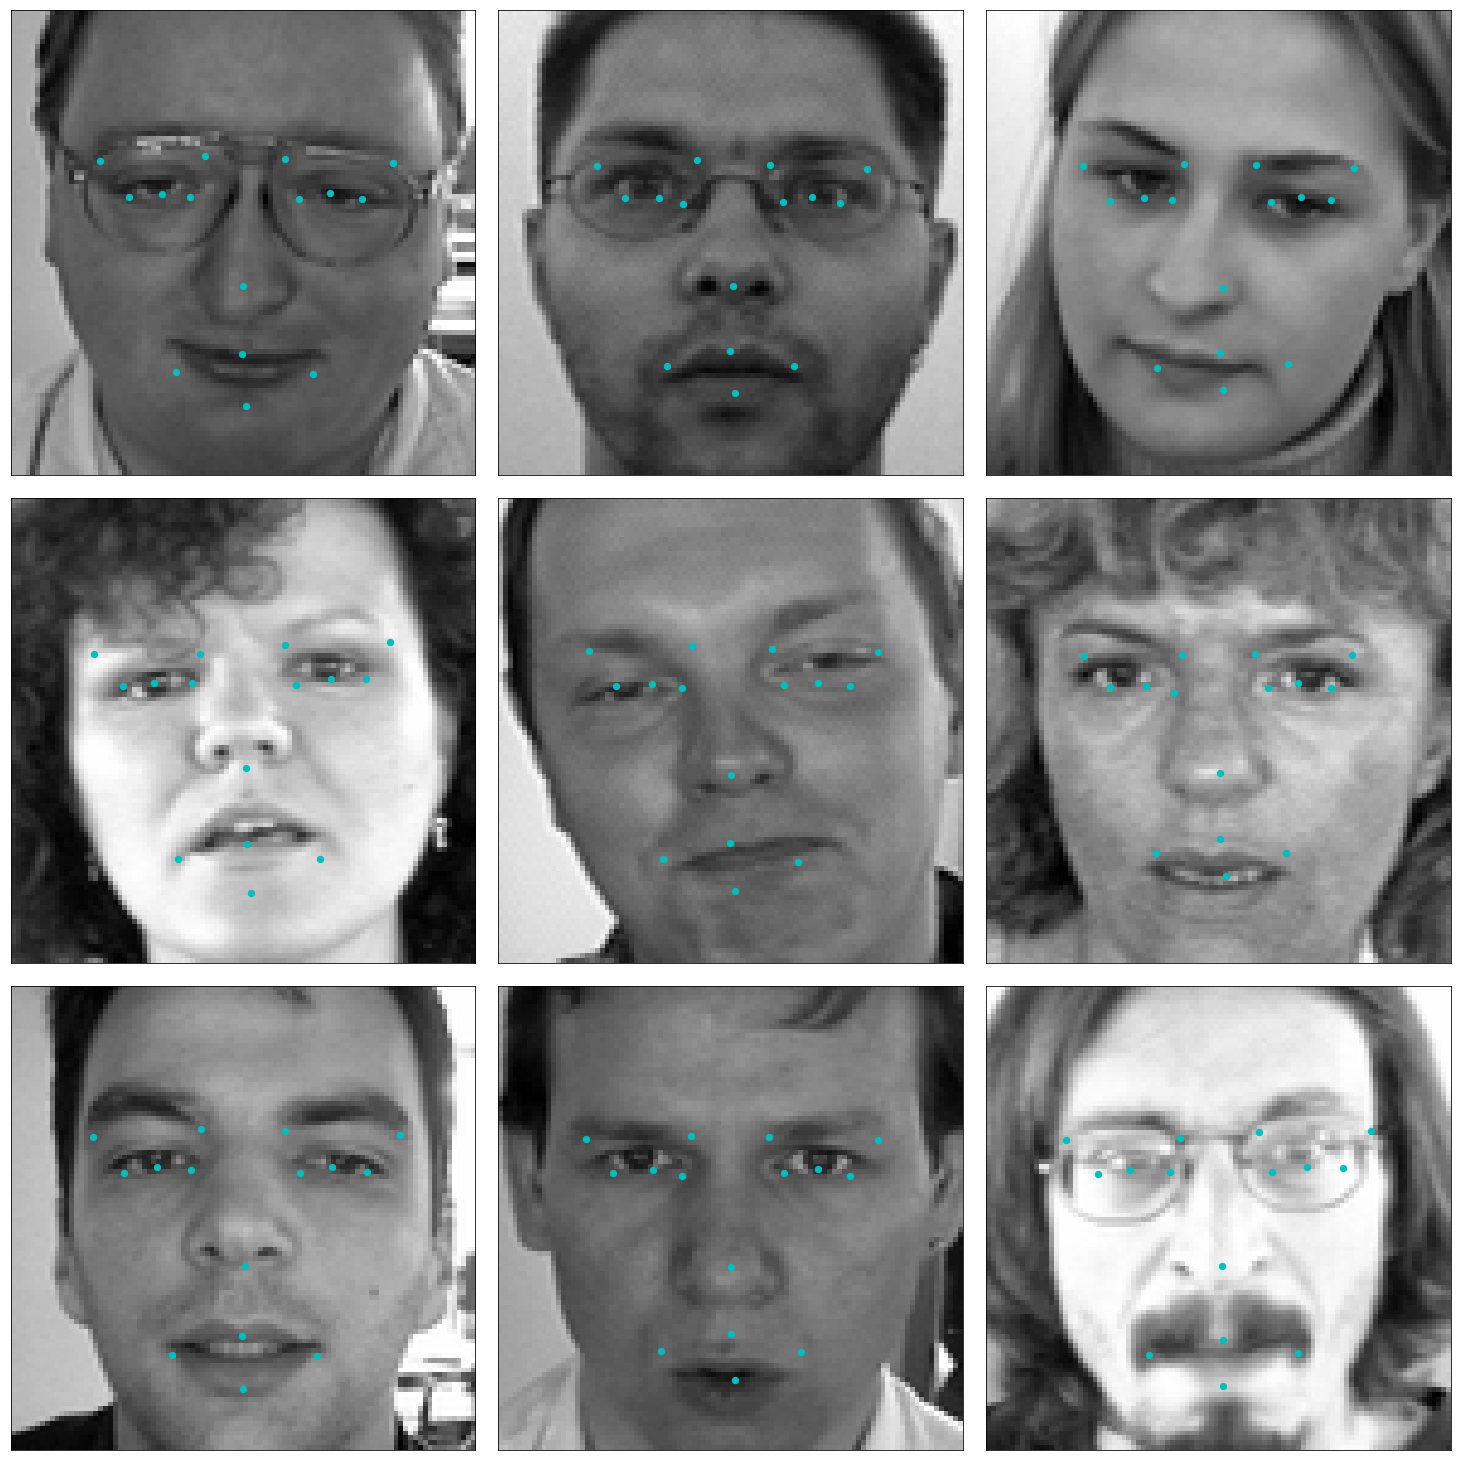

In [65]:
# predict the test set
X_test_02, y_test_pred_02 = predict_test(rst_02)
plot_samples(X_test_02,y_test_pred_02)

In [66]:
X_train_with_hist.shape

(4280, 1, 96, 96)

In [67]:
# store the results
methods.append('Histogram_Stretching')
train_set_size.append(len(X_train_with_hist))
num_epoch.append(35)
RMSE.append(RMSE_rst_02)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

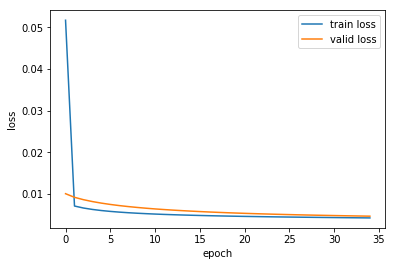

In [68]:
# print layer information
# draw loss curve
layer_info(rst_02)
draw_to_notebook(rst_02)
plot_loss(rst_02)

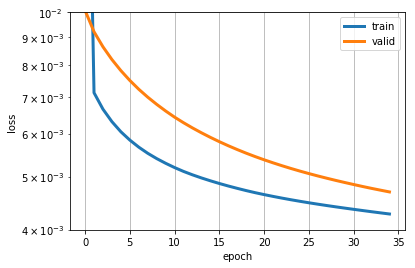

In [69]:
draw_loss_curve(rst_02)

### Data Augmentation 3 : Contrast Jittering (Reduction) 
- CR(X)=($& * X) + (1-$&) * mean(X)
- X is the 96x96x1 input and mean(X) is the average pixel value in X.
- pixel values are shifted slightly towards the images mean pixel value
- The degree of shift is determined by hyperparameter & which we set to 0.8 according to paper. The greater the value of 1- & the greater the shift towards the image’s mean.

In [70]:
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import os
import csv
import shelve
import pickle

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency
from sklearn.metrics import mean_squared_error as mse

In [71]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [72]:
X_train, y_train, y_name = load_data()
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [73]:
# define a plotting two picture function 
def plot_two(image1, p1, image2, p2):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(image1,(96,96)), cmap = 'Greys_r')
    for x, y in np.reshape(p1,(int(len(p1)/2), 2)):
        plt.plot(x, y, 'bo')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(image2,(96,96)), cmap = 'Greys_r')
    for x, y in np.reshape(p2,(int(len(p2)/2), 2)):
        plt.plot(x, y, 'bo')
    plt.axis('off')

In [74]:
# histogram stretching function
def contrast_jittering(image):
#     a, b = min(image), max(image) 
    mean_val = np.mean(image)
    #print(mean_val)
    para = 0.8
    return [para * p + (1 - para) * mean_val for p in image]

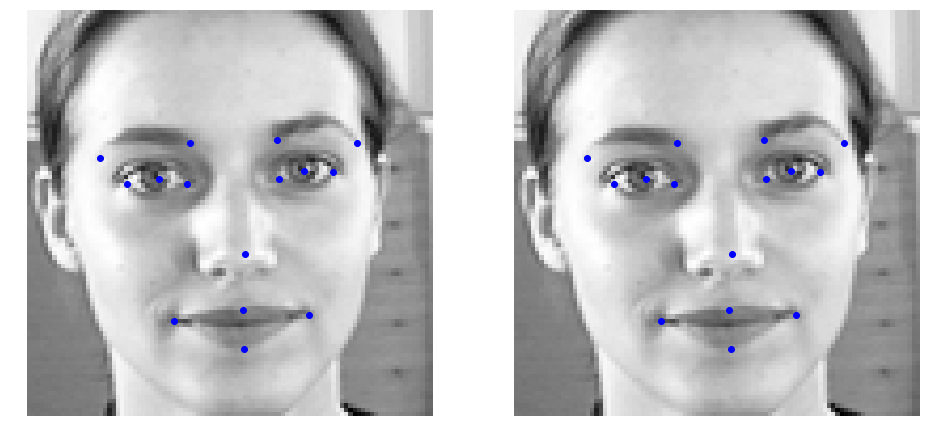

In [75]:
# plot an example
X_train_reduction = [contrast_jittering(x) for x in X_train]
image1 = X_train[23]
impage2 = X_train_reduction[23]
y1 = y_train[23] * 48 + 48
y2 = y_train[23] * 48 + 48
plot_two(image1, y1, impage2, y2)

In [76]:
# reshpe X_train_reduction as X_train before merge
X_train_reduction_arr = np.asarray(X_train_reduction)
X_train_reduction_arr = X_train_reduction_arr.reshape(-1, 1, 96, 96)

In [77]:
# merger X_train and X_train_reduction 
X_train_with_reduction = np.concatenate((X_train_2d, X_train_reduction_arr), axis = 0)
y_train_with_reduction = np.concatenate((y_train_2d, y_train_2d), axis = 0)
print('X_train_with_reduction shape : ', X_train_with_reduction.shape)
print('y_train_with_reduction shape : ', y_train_with_reduction.shape)

X_train_with_reduction shape :  (4280, 1, 96, 96)
y_train_with_reduction shape :  (4280, 30)


In [78]:
net_03 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [79]:
rst_03 = fit_model(net_03, X_train_with_reduction, y_train_with_reduction)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.03136     0.00922    3.40123  4.41s
      2     0.00842     0.00820    1.02719  4.41s
      3     0.00764     0.00751    1.01714  4.41s
      4     0.00707     0.00699    1.01117  4.41s
      5     0.00663     0.00658    1.00748  4.41s
      6     0.00628     0.00624    1.00515  4.41s
      7     0.00598     0.00596    1.00344  4.41s
      8     0.00573     0.00572    1.00226  4.41s
      9     0.00552     0.00551    1.00154  4.41s
     10     0.00533     0.00533    1.00087  4.41s
     11     0.00517     0.00517    1.00069  4.41s
     12     0.00503

In [80]:
# predict the train set with trained model
X_train_03, y_train_03, y_train_pred_03 = predict_train(rst_03)
RMSE_rst_03 = mse(y_train_03, y_train_pred_03) ** 0.5 * 48
print('RMSE value of rst_03 : ', RMSE_rst_03)

RMSE value of rst_03 :  3.127300579107561


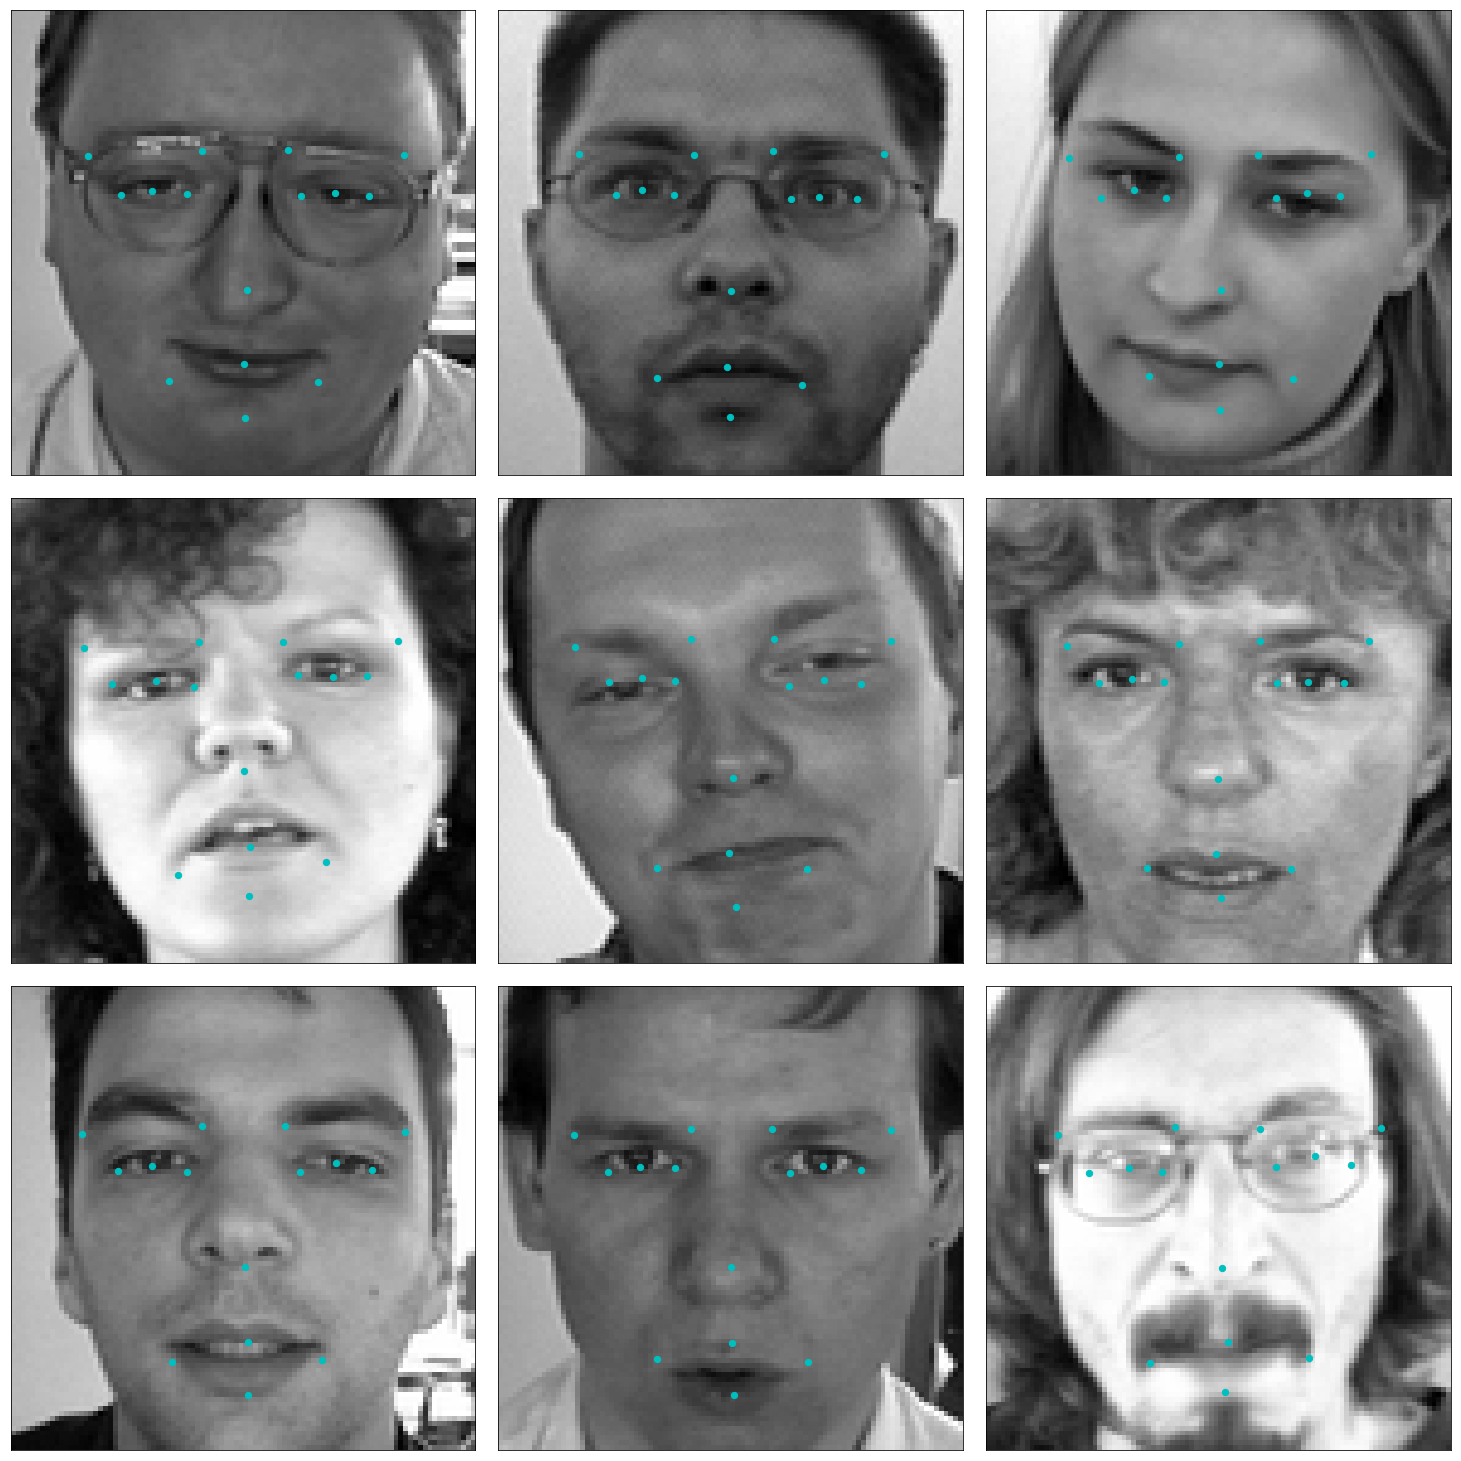

In [81]:
# predict the test set
X_test_03, y_test_pred_03 = predict_test(rst_03)
plot_samples(X_test_03,y_test_pred_03)

In [82]:
X_train_with_reduction.shape

(4280, 1, 96, 96)

In [83]:
# store the results
methods.append('Contrast_Jittering')
train_set_size.append(len(X_train_with_reduction))
num_epoch.append(35)
RMSE.append(RMSE_rst_03)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

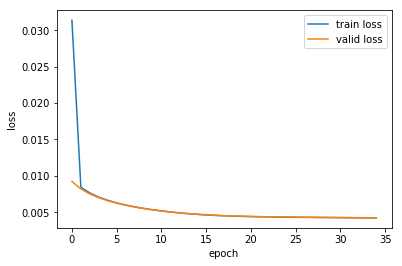

In [84]:
# print layer information
# draw loss curve
layer_info(rst_03)
draw_to_notebook(rst_03)
plot_loss(rst_03)

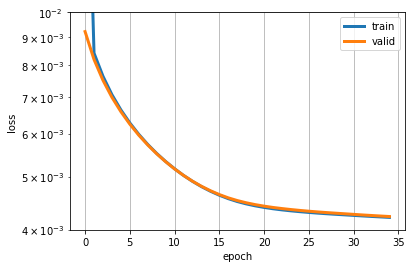

In [85]:
draw_loss_curve(rst_03)

## Data Augmentation 4  fill all null records with predict value: 
- predict naN records with rst_0 model
- fill naN with predict result 
- modelling again with filled naN dataset

In [86]:
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import os
import csv
import shelve
import pickle

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency
from sklearn.metrics import mean_squared_error as mse

In [87]:
# data Augmentation 4: fill naN records with prediction value 

In [88]:
# function to get null value data set
def load_naN_records():

    FTRAIN = 'data/training.csv'
    df = read_csv(os.path.expanduser(FTRAIN))  # load dataframes
    
    # get NaN records as nans dataframe
    nans = df[df.isnull().any(axis=1)]
    
    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    nans['Image'] = nans['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    # Define Input X
    X = np.vstack(nans['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1
    y_name = np.array(nans.columns[:-1])

    # Define output y
    y = nans[nans.columns[:-1]].values
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    X, y = shuffle(X, y, random_state=42)  # shuffle data set
    y = y.astype(np.float32)

    return X, y, nans   

In [89]:
X_nans, y_nans, nans = load_naN_records()

/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [90]:
# check loaded nan data shape 
print("X_nans.shape == {}".format(X_nans.shape))
print("y_nans.shape == {}; y_nans.min == {:.3f}; y_nans.max == {:.3f}".format(
    y_nans.shape, y_nans.min(), y_nans.max()))
#print(nans.columns)
print('nans.shape', nans.shape)
print('nans data type', type(nans))

X_nans.shape == (4909, 96, 96, 1)
y_nans.shape == (4909, 30); y_nans.min == nan; y_nans.max == nan
nans.shape (4909, 31)
nans data type <class 'pandas.core.frame.DataFrame'>


In [91]:
# reshape X_nans for merge
X_nans = X_nans.reshape(-1, 1, 96, 96)
print('X_nans.shape ', X_nans.shape)
print('X_nans.dtype', X_nans.dtype)

X_nans.shape  (4909, 1, 96, 96)
X_nans.dtype float32


In [92]:
def predict_nans(model, X_train, y_train, X_nans):
    
    # train model net_00 with origional train data
    rst_00 = fit_model(model, X_train, y_train)
    
    # reshape X_nans to (96, 96, 1) for merge
    X_nans = X_nans.reshape(-1, 1, 96, 96) 
   
    # predict train set for model evaluation
    X_train_00, y_train_00, y_train_pred_00 = predict_train(rst_00) 
    RMSE_rst_00 = mse(y_train_00, y_train_pred_00) ** 0.5 * 48
    print('RMSE value of rst_00 : ', RMSE_rst_00)
    draw_loss_curve(rst_00)
    plot_loss(rst_00)
    
    # predict y_nan with X_nans
    y_pred = rst_00.predict(X_nans)
    
    return X_nans, y_pred, RMSE_rst_00

In [93]:
def fill_na_with_predicted(y_nans, y_pred):
    y_nans_fill = y_nans.copy()
    for i in range(len(y_nans_fill)):
        for j in range(len(y_nans_fill[0])):
            if (np.isnan(y_nans_fill[i][j])):
                #print('y_pred[i][j] value : ', y_pred[i][j])
                y_nans_fill[i][j] = y_pred[i][j] 
                #print('y_pred[i][j] value : ', y_pred[i][j])
    return y_nans_fill

In [94]:
net_00 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [95]:
# load orignal train data without null value records 
X_train_2d, y_train_2d, y_name = load2d() 
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


In [96]:
X_train, y_train, y_name = load_data()
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}; y_train.min = {:.3f}; y_train.max = {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
print('y_name.shape : ', y_name.shape)
print('y_name type : ', type(y_name))

X_train.shape = (2140, 96, 96, 1)
y_train.shape = (2140, 30); y_train.min = -0.920; y_train.max = 0.996
y_name.shape :  (30,)
y_name type :  <class 'numpy.ndarray'>


# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.07571     0.01307    5.79147  2.22s
      2     0.00929     0.00787    1.18058  2.22s
      3     0.00787     0.00735    1.07093  2.22s
      4     0.00745     0.00699    1.06510  2.22s
      5     0.00712     0.00669    1.06352  2.22s
      6     0.00684     0.00644    1.06229  2.22s
      7     0.00660     0.00622    1.06169  2.22s
      8     0.00639     0.00601    1.06240  2.22s
      9     0.00620     0.00584    1.06141  2.22s
     10     0.00603     0.00568    1.06131  2.22s
     11     0.00589     0.00555    1.06103  2.22s
     12     0.00576

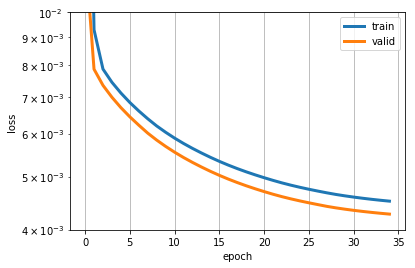

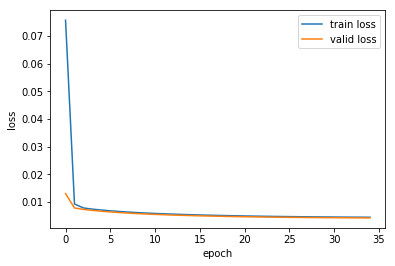

In [97]:
# predict null value data, fill null value record with the predicted results
X_nans, y_pred, RMSE_rst_00 = predict_nans(net_00, X_train_2d, y_train_2d, X_nans)

In [98]:
# check shape and data type before merge
print('X_nans shape ', X_nans.shape)
print('y_nans shape ', y_nans.shape)
print('y_nans dtype ', y_nans.dtype)
print()
print('y_pred shape ', y_pred.shape)
print('y_pred dtype ', y_pred.dtype)
print('y null values ', y_nans[np.isnan(y_nans)])

X_nans shape  (4909, 1, 96, 96)
y_nans shape  (4909, 30)
y_nans dtype  float32

y_pred shape  (4909, 30)
y_pred dtype  float32
y null values  [nan nan nan ... nan nan nan]


In [99]:
# fill null values in y_nans with y_pred values
y_nans_fill = fill_na_with_predicted(y_nans, y_pred)

In [100]:
print(type(y_nans_fill))
print(y_nans_fill.shape)

<class 'numpy.ndarray'>
(4909, 30)


In [101]:
print(y_nans_fill[1])
print()
print(y_nans[1])
print()
print(y_pred[1])
mm = y_nans[np.isnan(y_nans)]
print(len(mm))
ff = y_nans_fill[np.isnan(y_nans_fill)]
print(len(ff))

[ 0.3526769  -0.21104793 -0.37189862 -0.1528231   0.23768167 -0.19222145
  0.51066625 -0.22045413 -0.236285   -0.21214303 -0.5140504  -0.19399363
  0.17703944 -0.37271315  0.6461567  -0.36375794 -0.17467362 -0.38554373
 -0.6515193  -0.35860497  0.11977758  0.42942518  0.31907672  0.5749994
 -0.28996515  0.56068385  0.01240378  0.48593342  0.10036931  0.7723045 ]

[ 0.3526769  -0.21104793 -0.37189862 -0.1528231          nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan  0.11977758  0.42942518         nan         nan
         nan         nan         nan         nan  0.10036931  0.7723045 ]

[ 0.36046368 -0.21500595 -0.35561073 -0.21652398  0.23768167 -0.19222145
  0.51066625 -0.22045413 -0.236285   -0.21214303 -0.5140504  -0.19399363
  0.17703944 -0.37271315  0.6461567  -0.36375794 -0.17467362 -0.38554373
 -0.6515193  -0.35860497  0.01006924  0.18563749

In [102]:
print('y_nans shape ', y_nans.shape)
print('y_pred shape ', y_pred.shape)
print('y_nans dtype ', y_nans.dtype)
print('y_pred dtype ', y_pred.dtype)
missing = y_nans_fill[np.isnan(y_nans_fill)]
print(missing)

y_nans shape  (4909, 30)
y_pred shape  (4909, 30)
y_nans dtype  float32
y_pred dtype  float32
[]


In [103]:
# merge with the non - naN train dataset
X_train_with_na_1 = np.concatenate((X_train_2d, X_nans), axis = 0)
y_train_with_na_1 = np.concatenate((y_train_2d, y_nans_fill), axis = 0)

In [104]:
# merge with the non - naN train dataset
X_train_with_na_2 = np.concatenate((X_train_2d, X_nans), axis = 0)
y_train_with_na_2 = np.concatenate((y_train_2d, y_pred), axis = 0)

In [105]:
# check data set shape and data type before modeling 
print(X_train_with_na_1.shape)
print(y_train_with_na_1.shape)
print(type(X_train_with_na_1))
print(type(X_train_with_na_1))
missing = y_train_with_na_1[np.isnan(y_train_with_na_1)]
print(missing)

(7049, 1, 96, 96)
(7049, 30)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[]


In [106]:
# check data set shape and data type before modeling 
print(X_train_with_na_2.shape)
print(y_train_with_na_2.shape)
print(type(X_train_with_na_2))
print(type(X_train_with_na_2))
missing = y_train_with_na_2[np.isnan(y_train_with_na_2)]
print(missing)

(7049, 1, 96, 96)
(7049, 30)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[]


In [107]:
net_04 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [108]:
rst_04_01 = fit_model(net_04, X_train_with_na_1, y_train_with_na_1)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.03088     0.00863    3.57609  7.26s
      2     0.00412     0.00800    0.51433  7.25s
      3     0.00381     0.00759    0.50151  7.25s
      4     0.00359     0.00728    0.49279  7.25s
      5     0.00343     0.00704    0.48634  7.25s
      6     0.00330     0.00686    0.48162  7.25s
      7     0.00321     0.00671    0.47825  7.25s
      8     0.00314     0.00659    0.47577  7.25s
      9     0.00308     0.00649    0.47403  7.25s
     10     0.00303     0.00641    0.47280  7.26s
     11     0.00300     0.00635    0.47204  7.25s
     12     0.00297

In [109]:
# predict the train set with trained model
X_train_04_01, y_train_04_01, y_train_pred_04_01 = predict_train(rst_04_01)
RMSE_rst_04_01 = mse(y_train_04_01, y_train_pred_04_01) ** 0.5 * 48
print('RMSE value of rst_04_01 : ', RMSE_rst_04_01)

RMSE value of rst_04_01 :  3.6685617473335133


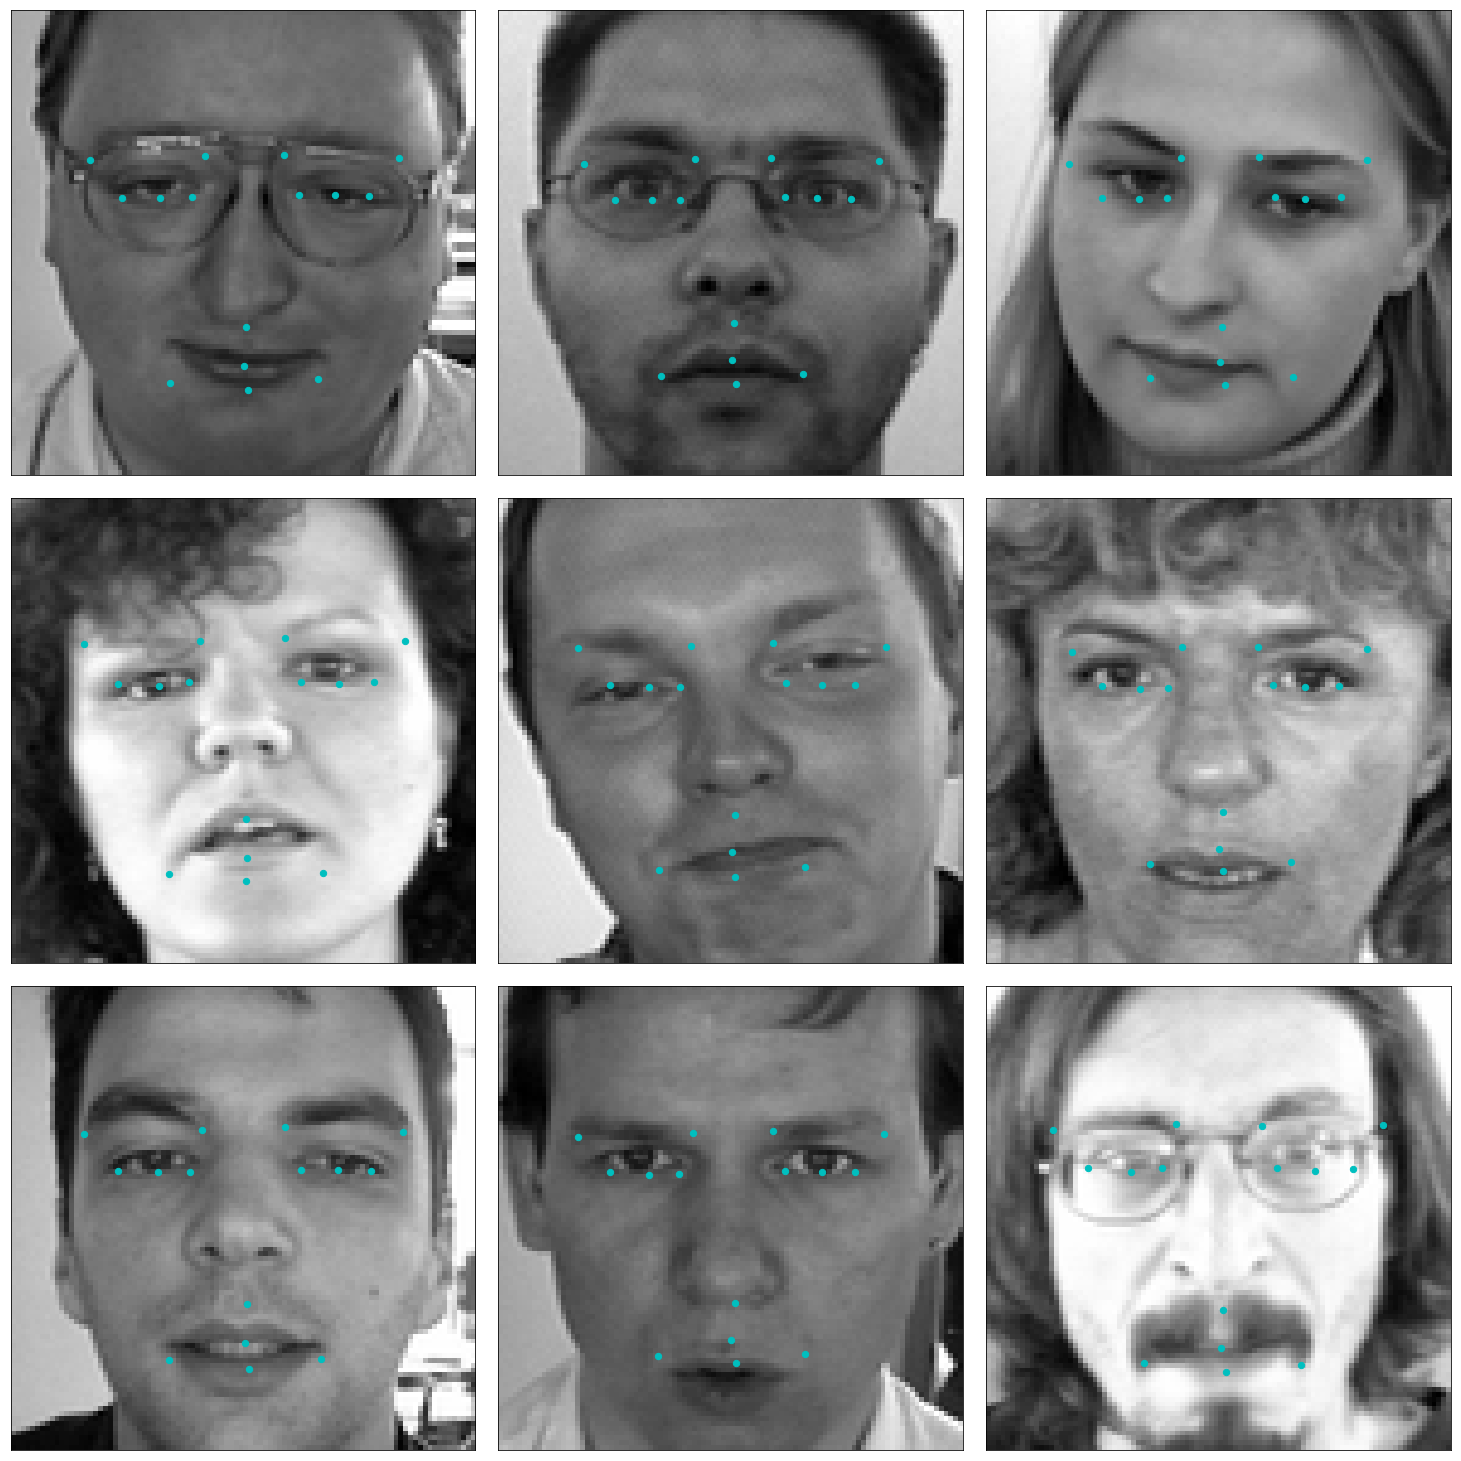

In [110]:
# predict the test set
X_test_04_01, y_test_pred_04_01 = predict_test(rst_04_01)
plot_samples(X_test_04_01,y_test_pred_04_01)

In [111]:
X_train_with_na_1.shape

(7049, 1, 96, 96)

In [112]:
# store the results
methods.append('Fill_null_value_with_predicted')
train_set_size.append(len(X_train_with_na_1))
num_epoch.append(35)
RMSE.append(RMSE_rst_04_01)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

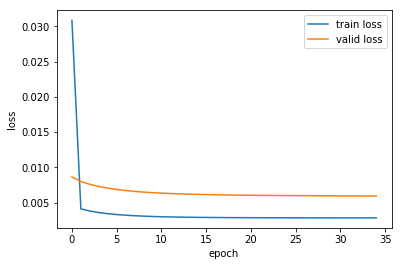

In [113]:
# print layer information
# draw loss curve
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()
layer_info(rst_04_01)
draw_to_notebook(rst_04_01)
plot_loss(rst_04_01)

In [114]:
rst_04_02 = fit_model(net_04, X_train_with_na_2, y_train_with_na_2)

     36     0.00076     0.00461    0.16442  7.26s
     37     0.00062     0.00461    0.13366  7.25s
     38     0.00061     0.00460    0.13357  7.25s
     39     0.00061     0.00460    0.13351  7.25s
     40     0.00061     0.00460    0.13344  7.25s
     41     0.00061     0.00459    0.13337  7.25s
     42     0.00061     0.00459    0.13331  7.26s
     43     0.00061     0.00459    0.13325  7.25s
     44     0.00061     0.00459    0.13321  7.25s
     45     0.00061     0.00459    0.13317  7.25s
     46     0.00061     0.00458    0.13314  7.26s
     47     0.00061     0.00458    0.13310  7.25s
     48     0.00061     0.00458    0.13306  7.25s
     49     0.00061     0.00458    0.13303  7.25s
     50     0.00061     0.00458    0.13300  7.25s
     51     0.00061     0.00458    0.13296  7.25s
     52     0.00061     0.00458    0.13293  7.25s
     53     0.00061     0.00457    0.13290  7.25s
     54     0.00061     0.00457    0.13287  7.25s
     55     0.00061     0.00457    0.13283  7.26s


In [115]:
# predict the train set with trained model
X_train_04_02, y_train_04_02, y_train_pred_04_02 = predict_train(rst_04_02)
RMSE_rst_04_02 = mse(y_train_04_02, y_train_pred_04_02) ** 0.5 * 48
print('RMSE value of rst_04_02 : ', RMSE_rst_04_02)

RMSE value of rst_04_02 :  3.214024250431593


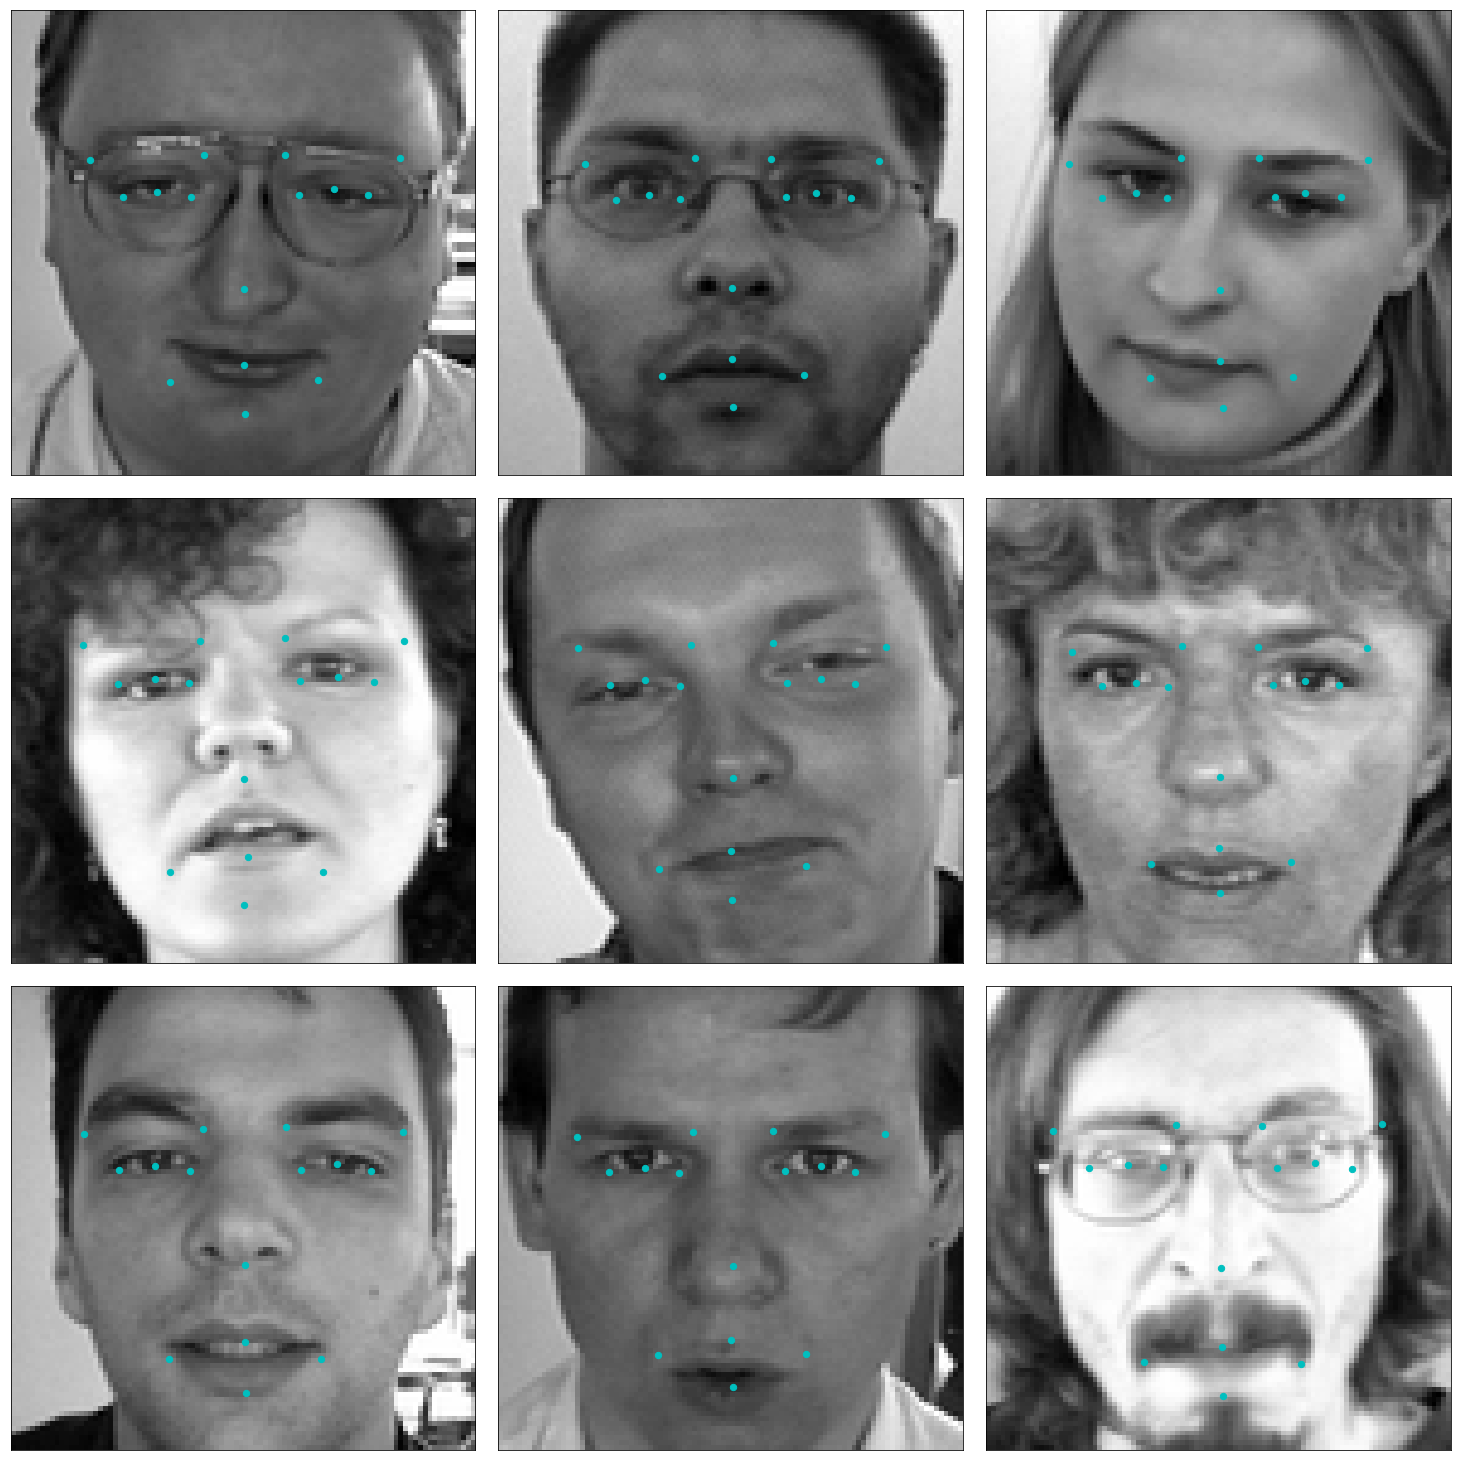

In [116]:
# predict the test set
X_test_04_02, y_test_pred_04_02 = predict_test(rst_04_02)
plot_samples(X_test_04_02,y_test_pred_04_02)

In [117]:
X_train_with_na_2.shape

(7049, 1, 96, 96)

In [118]:
# store the results
methods.append('Replace_null_records_with_predicted')
train_set_size.append(len(X_train_with_na_2))
num_epoch.append(35)
RMSE.append(RMSE_rst_04_02)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

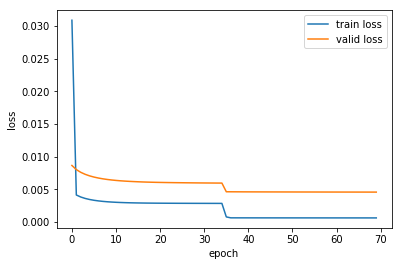

In [119]:
# print layer information
# draw loss curve
layer_info(rst_04_02)
draw_to_notebook(rst_04_02)
plot_loss(rst_04_02)

In [120]:
import pandas as pd

In [121]:
def display_results(methods, train_set_size, num_epoch, RMSE):
    cols = ['NO.',
            'Methods_Applied', 
            'Train_Set_Size', 
            '#._Of_Epoch', 
            'RMSE', 
            'Improvement', 
            'Overfitting']  
    results_table = pd.DataFrame(columns = cols)
    results_table['NO.'] = ['0','00','01','02', '03','04','05']
    results_table['Methods_Applied'] = methods
    results_table['Train_Set_Size'] = train_set_size
    results_table['#._Of_Epoch'] = num_epoch
    results_table['RMSE'] = RMSE
    results_table['Improvement'] = ['NA', '-','+','+','=', '-','+']
    results_table['Overfitting'] = ['NO', 'YES', 'NO', 'NO', 'NO', 'YES','YES']
    return results_table

In [122]:
methods

['Baseline',
 'Regulization_with_dropout_layers',
 'Flipping',
 'Histogram_Stretching',
 'Contrast_Jittering',
 'Fill_null_value_with_predicted',
 'Replace_null_records_with_predicted']

In [123]:
results = display_results(methods, train_set_size, num_epoch, RMSE)
results

,NO.,Methods_Applied,Train_Set_Size,#._Of_Epoch,RMSE,Improvement,Overfitting
0,0,Baseline,2140,35,3.214488,NA,NO
1,00,Regulization_with_dropout_layers,2140,35,5.290542,-,YES
2,01,Flipping,4280,35,3.194874,+,NO
3,02,Histogram_Stretching,4280,35,3.298490,+,NO
4,03,Contrast_Jittering,4280,35,3.127301,=,NO
5,04,Fill_null_value_with_predicted,7049,35,3.668562,-,YES
6,05,Replace_null_records_with_predicted,7049,35,3.214024,+,YES


## combine positive sets: 
- original train set(2140)
- flipping set(2140) 
- Hisogram Stretch(2140) 
- reduction(2140) 
- Null records with predicted Y

In [124]:
# original train set(2140)
X_train_2d, y_train_2d, y_name = load2d() 
print('X_train_2d shape', X_train_2d.shape)
print('y_train_2d shape', y_train_2d.shape)
print('X_train_2d dtype', X_train_2d.dtype)
print('y_train_2d dtype', y_train_2d.dtype)

X_train_2d shape (2140, 1, 96, 96)
y_train_2d shape (2140, 30)
X_train_2d dtype float32
y_train_2d dtype float32


In [125]:
# flipping set(2140)
X_train_merged, y_train_merged, X_flipped, y_flipped = flip_faces_horizontally(X_train_2d, y_train_2d, y_name)
print('X_flipped shape', X_flipped.shape)
print('y_flipped shape', y_flipped.shape)
print('X_flipped dtype', X_flipped.dtype)
print('y_flipped dtype', y_flipped.dtype)

After merge X:(4280, 1, 96, 96), y:(4280, 30)
X_flipped shape (2140, 1, 96, 96)
y_flipped shape (2140, 30)
X_flipped dtype float32
y_flipped dtype float64


In [126]:
# Hisogram Stretch(2140)
X_train_hist_arr = X_train_hist_arr.reshape(-1, 1, 96, 96)
y_train_hist = y_train_2d.copy()
print('X_train_hist_arr shape', X_train_hist_arr.shape)
print('y_train_hist shape', y_train_hist.shape)
print('X_train_hist_arr dtype', X_train_hist_arr.dtype)
print('y_train_hist dtype', y_train_hist.dtype)

X_train_hist_arr shape (2140, 1, 96, 96)
y_train_hist shape (2140, 30)
X_train_hist_arr dtype float32
y_train_hist dtype float32


In [127]:
# reduction(2140)
X_train_reduction_arr = X_train_reduction_arr.reshape(-1, 1, 96, 96)
y_train_reduction = y_train_2d.copy()
print('X_train_reduction_arr shape', X_train_reduction_arr.shape)
print('y_train_reduction shape', y_train_reduction.shape)
print('X_train_reduction_arr dtype', X_train_reduction_arr.dtype)
print('y_train_reduction dtype', y_train_reduction.dtype)

X_train_reduction_arr shape (2140, 1, 96, 96)
y_train_reduction shape (2140, 30)
X_train_reduction_arr dtype float32
y_train_reduction dtype float32


/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


     36     0.00450     0.00426    1.05574  2.23s
     37     0.00448     0.00425    1.05543  2.22s
     38     0.00447     0.00424    1.05510  2.22s
     39     0.00446     0.00423    1.05480  2.22s
     40     0.00445     0.00422    1.05452  2.22s
     41     0.00444     0.00421    1.05424  2.22s
     42     0.00443     0.00420    1.05399  2.22s
     43     0.00442     0.00419    1.05376  2.22s
     44     0.00441     0.00419    1.05354  2.22s
     45     0.00440     0.00418    1.05331  2.22s
     46     0.00440     0.00417    1.05310  2.22s
     47     0.00439     0.00417    1.05287  2.22s
     48     0.00438     0.00416    1.05264  2.22s
     49     0.00437     0.00416    1.05244  2.22s
     50     0.00437     0.00415    1.05225  2.22s
     51     0.00436     0.00415    1.05209  2.22s
     52     0.00436     0.00414    1.05190  2.22s
     53     0.00435     0.00414    1.05166  2.22s
     54     0.00434     0.00413    1.05147  2.22s
     55     0.00434     0.00413    1.05128  2.22s


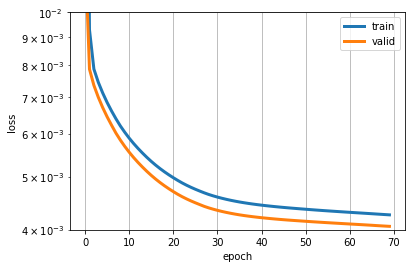

X_nans shape (4909, 1, 96, 96)
y_pred (4909, 30)
X_nans dtype float32
y_pred float32


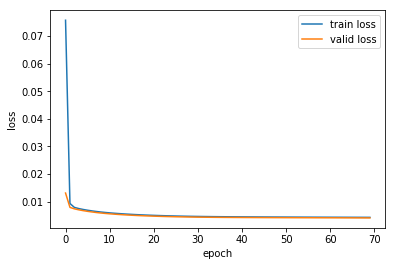

In [128]:
# Null records with predicted Y
X_nans, y_nans, nans = load_naN_records()
X_nans, y_pred, RMSE_rst_00 = predict_nans(net_00, X_train_2d, y_train_2d, X_nans)
print('X_nans shape', X_nans.shape)
print('y_pred', y_pred.shape)
print('X_nans dtype', X_nans.dtype)
print('y_pred', y_pred.dtype)

In [129]:
# merge

XX_train = np.concatenate((X_train_2d, X_flipped), axis = 0)
yy_train = np.concatenate((y_train_2d, y_flipped), axis = 0)
print(XX_train.shape)
print(yy_train.shape)

(4280, 1, 96, 96)
(4280, 30)


In [130]:
XX_train = np.concatenate((XX_train, X_train_hist_arr), axis = 0)
yy_train = np.concatenate((yy_train, y_train_hist), axis = 0)
print(XX_train.shape)
print(yy_train.shape)

(6420, 1, 96, 96)
(6420, 30)


In [131]:
XX_train = np.concatenate((XX_train, X_train_reduction_arr), axis = 0)
yy_train = np.concatenate((yy_train, y_train_reduction), axis = 0)
print(XX_train.shape)
print(yy_train.shape)

(8560, 1, 96, 96)
(8560, 30)


In [132]:
XX_train = np.concatenate((XX_train, X_nans), axis = 0)
yy_train = np.concatenate((yy_train, y_pred), axis = 0)
print(XX_train.shape)
print(yy_train.shape)

(13469, 1, 96, 96)
(13469, 30)


In [133]:
print('XX_train shape', XX_train.shape)
print('yy_train shape ', yy_train.shape)
print('XX_train dtype', XX_train.dtype)
print('yy_train', yy_train.dtype)

XX_train shape (13469, 1, 96, 96)
yy_train shape  (13469, 30)
XX_train dtype float32
yy_train float64


In [134]:
yy_train = yy_train.astype('float32')

In [135]:
print('XX_train shape', XX_train.shape)
print('yy_train shape ', yy_train.shape)
print('XX_train dtype', XX_train.dtype)
print('yy_train', yy_train.dtype)

XX_train shape (13469, 1, 96, 96)
yy_train shape  (13469, 30)
XX_train dtype float32
yy_train float32


In [136]:
net_05 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.8,

    regression=True,
    max_epochs=35,
    verbose=1,
    )

In [137]:
rst_05 = fit_model(net_05, XX_train, yy_train)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.01932     0.00630    3.06518  13.89s
      2     0.00370     0.00552    0.67033  13.88s
      3     0.00321     0.00507    0.63403  13.88s
      4     0.00292     0.00478    0.60996  13.88s
      5     0.00273     0.00461    0.59302  13.88s
      6     0.00262     0.00450    0.58191  13.88s
      7     0.00255     0.00443    0.57498  13.88s
      8     0.00250     0.00439    0.57058  13.88s
      9     0.00247     0.00435    0.56829  13.89s
     10     0.00245     0.00433    0.56685  13.88s
     11     0.00244     0.00431    0.56582  13.88s
     12

In [138]:
# predict the train set with trained model
X_train_05, y_train_05, y_train_pred_05 = predict_train(rst_05)
RMSE_rst_05 = mse(y_train_05, y_train_pred_05) ** 0.5 * 48
print('RMSE value of rst_05 : ', RMSE_rst_05)

RMSE value of rst_05 :  2.9998710723829625


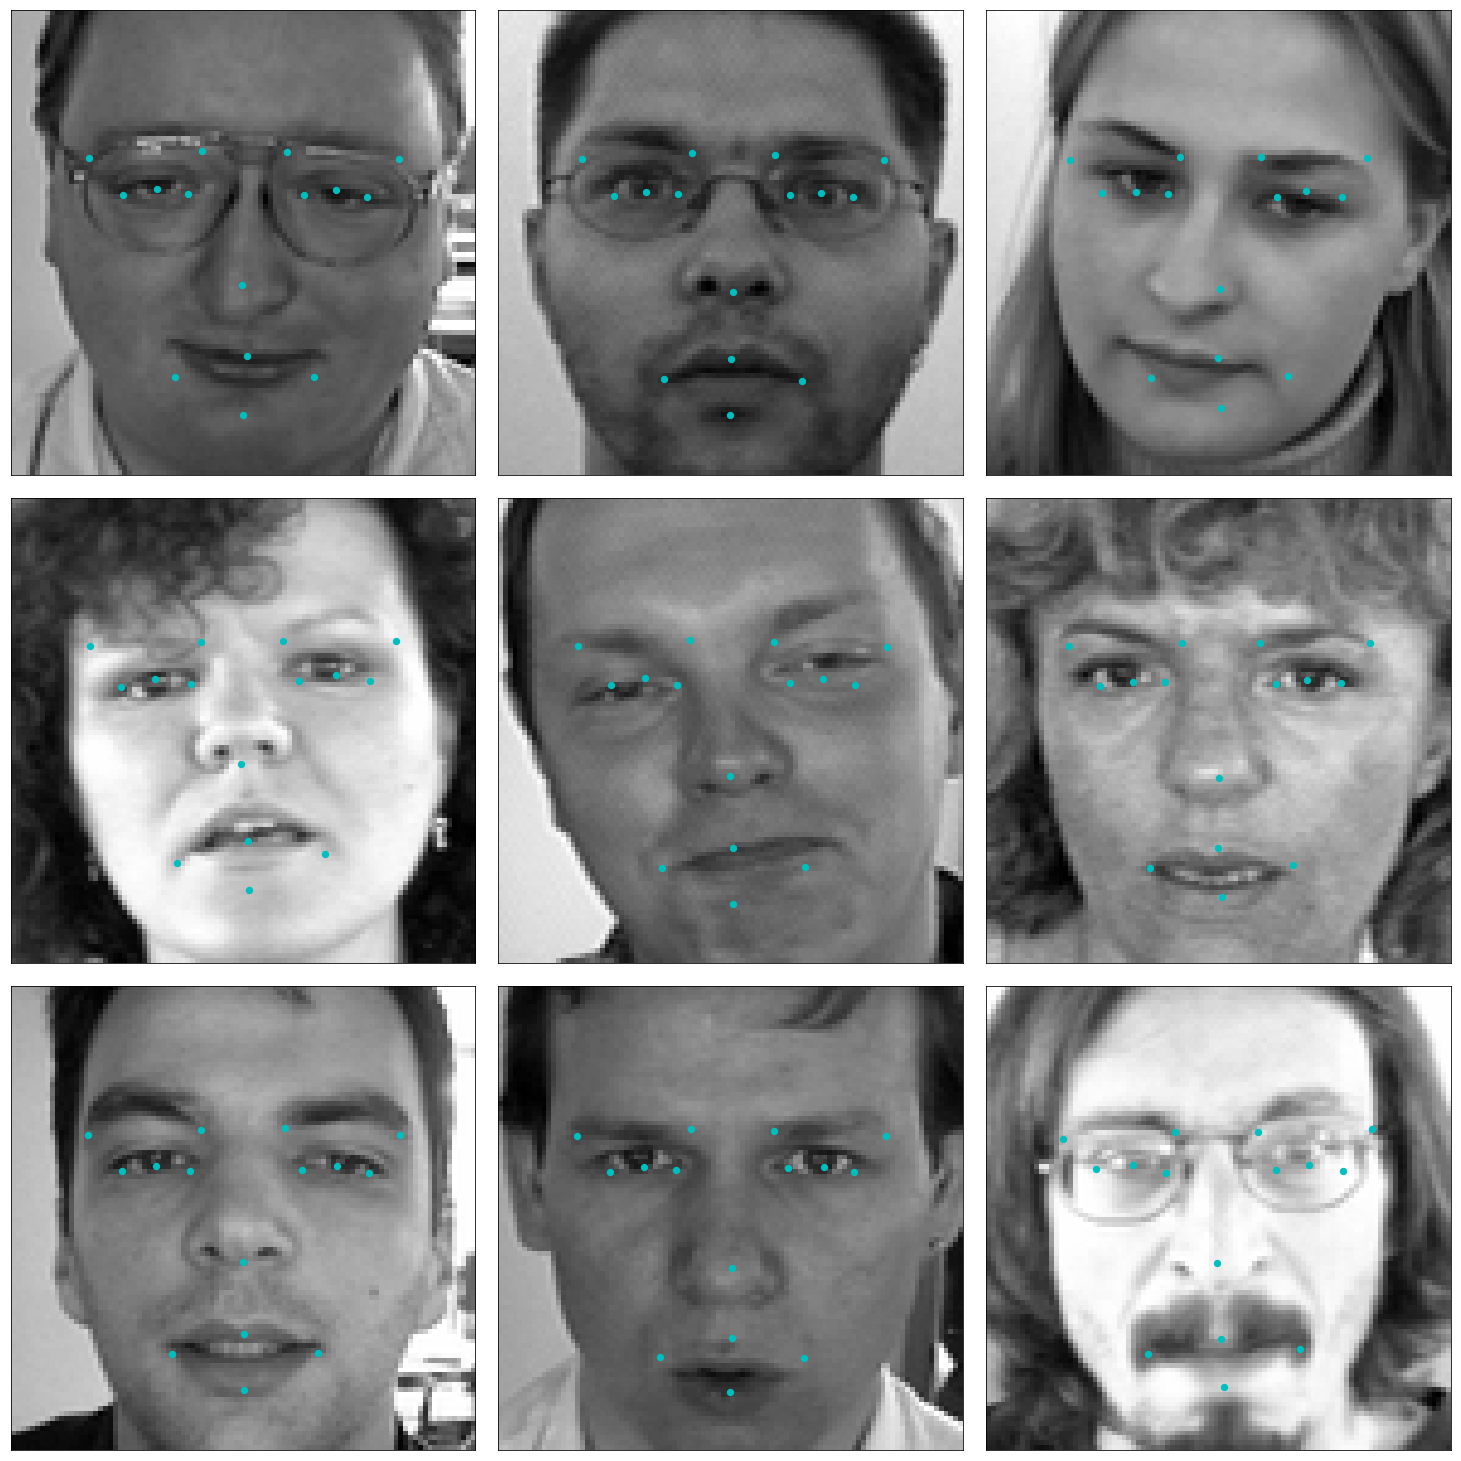

In [139]:
# predict the test set
X_test_05, y_test_pred_05 = predict_test(rst_05)
plot_samples(X_test_05,y_test_pred_05)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

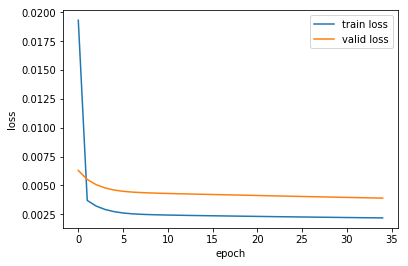

In [140]:
# print layer information
# draw loss curve
layer_info(rst_05)
draw_to_notebook(rst_05)
plot_loss(rst_05)

In [141]:
XX_train.shape

(13469, 1, 96, 96)

In [142]:
# store the results
methods.append('Flipping+Hist+Reduction+ReplaceNaN')
train_set_size.append(len(XX_train))
num_epoch.append(35)
RMSE.append(RMSE_rst_05)

In [143]:
methods

['Baseline',
 'Regulization_with_dropout_layers',
 'Flipping',
 'Histogram_Stretching',
 'Contrast_Jittering',
 'Fill_null_value_with_predicted',
 'Replace_null_records_with_predicted',
 'Flipping+Hist+Reduction+ReplaceNaN']

In [144]:
def display_results(methods, train_set_size, num_epoch, RMSE):
    cols = ['NO.',
            'Methods_Applied', 
            'Train_Set_Size', 
            '#._Of_Epoch', 
            'RMSE', 
            'Improvement', 
            'Overfitting']  
    results_table = pd.DataFrame(columns = cols)
    results_table['NO.'] = ['0','00','01','02', '03','04','05','06']
    results_table['Methods_Applied'] = methods
    results_table['Train_Set_Size'] = train_set_size
    results_table['#._Of_Epoch'] = num_epoch
    results_table['RMSE'] = RMSE
    results_table['Improvement'] = ['NA', '-','+','+','=', '-','+','+']
    results_table['Overfitting'] = ['NO', 'YES', 'NO', 'NO', 'NO', 'YES','YES','YES']
    return results_table

In [145]:
results = display_results(methods, train_set_size, num_epoch, RMSE)
results

,NO.,Methods_Applied,Train_Set_Size,#._Of_Epoch,RMSE,Improvement,Overfitting
0,0,Baseline,2140,35,3.214488,NA,NO
1,00,Regulization_with_dropout_layers,2140,35,5.290542,-,YES
2,01,Flipping,4280,35,3.194874,+,NO
3,02,Histogram_Stretching,4280,35,3.298490,+,NO
4,03,Contrast_Jittering,4280,35,3.127301,=,NO
5,04,Fill_null_value_with_predicted,7049,35,3.668562,-,YES
6,05,Replace_null_records_with_predicted,7049,35,3.214024,+,YES
7,06,Flipping+Hist+Reduction+ReplaceNaN,13469,35,2.999871,+,YES


In [146]:
net_06 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=True,
    max_epochs=200,
    verbose=1,
    )

In [147]:
rst_06 = fit_model(net_06, XX_train, yy_train)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.01554     0.00598    2.59680  13.88s
      2     0.00337     0.00510    0.66188  13.87s
      3     0.00289     0.00472    0.61231  13.88s
      4     0.00267     0.00455    0.58743  13.88s
      5     0.00257     0.00446    0.57605  13.87s
      6     0.00252     0.00442    0.57054  13.87s
      7     0.00249     0.00439    0.56780  13.87s
      8     0.00247     0.00437    0.56632  13.87s
      9     0.00246     0.00435    0.56547  13.87s
     10     0.00244     0.00433    0.56481  13.87s
     11     0.00243     0.00431    0.56429  13.88s
     12

    114     0.00152     0.00246    0.61715  13.88s
    115     0.00152     0.00245    0.61762  13.89s
    116     0.00151     0.00245    0.61797  13.89s
    117     0.00151     0.00244    0.61832  13.89s
    118     0.00151     0.00243    0.61872  13.89s
    119     0.00150     0.00243    0.61916  13.89s
    120     0.00150     0.00242    0.61956  13.89s
    121     0.00150     0.00241    0.61983  13.89s
    122     0.00149     0.00241    0.62011  13.88s
    123     0.00149     0.00240    0.62046  13.89s
    124     0.00149     0.00240    0.62076  13.89s
    125     0.00148     0.00239    0.62101  13.89s
    126     0.00148     0.00239    0.62142  13.88s
    127     0.00148     0.00238    0.62181  13.88s
    128     0.00148     0.00237    0.62218  13.89s
    129     0.00147     0.00237    0.62242  13.89s
    130     0.00147     0.00236    0.62215  13.89s
    131     0.00147     0.00236    0.62263  13.89s
    132     0.00147     0.00235    0.62300  13.89s
    133     0.00146     0.00235

In [148]:
# predict the train set with trained model
X_train_06, y_train_06, y_train_pred_06 = predict_train(rst_06)
RMSE_rst_06 = mse(y_train_06, y_train_pred_06) ** 0.5 * 48
print('RMSE value of rst_06 : ', RMSE_rst_06)

RMSE value of rst_06 :  2.1733614274073583


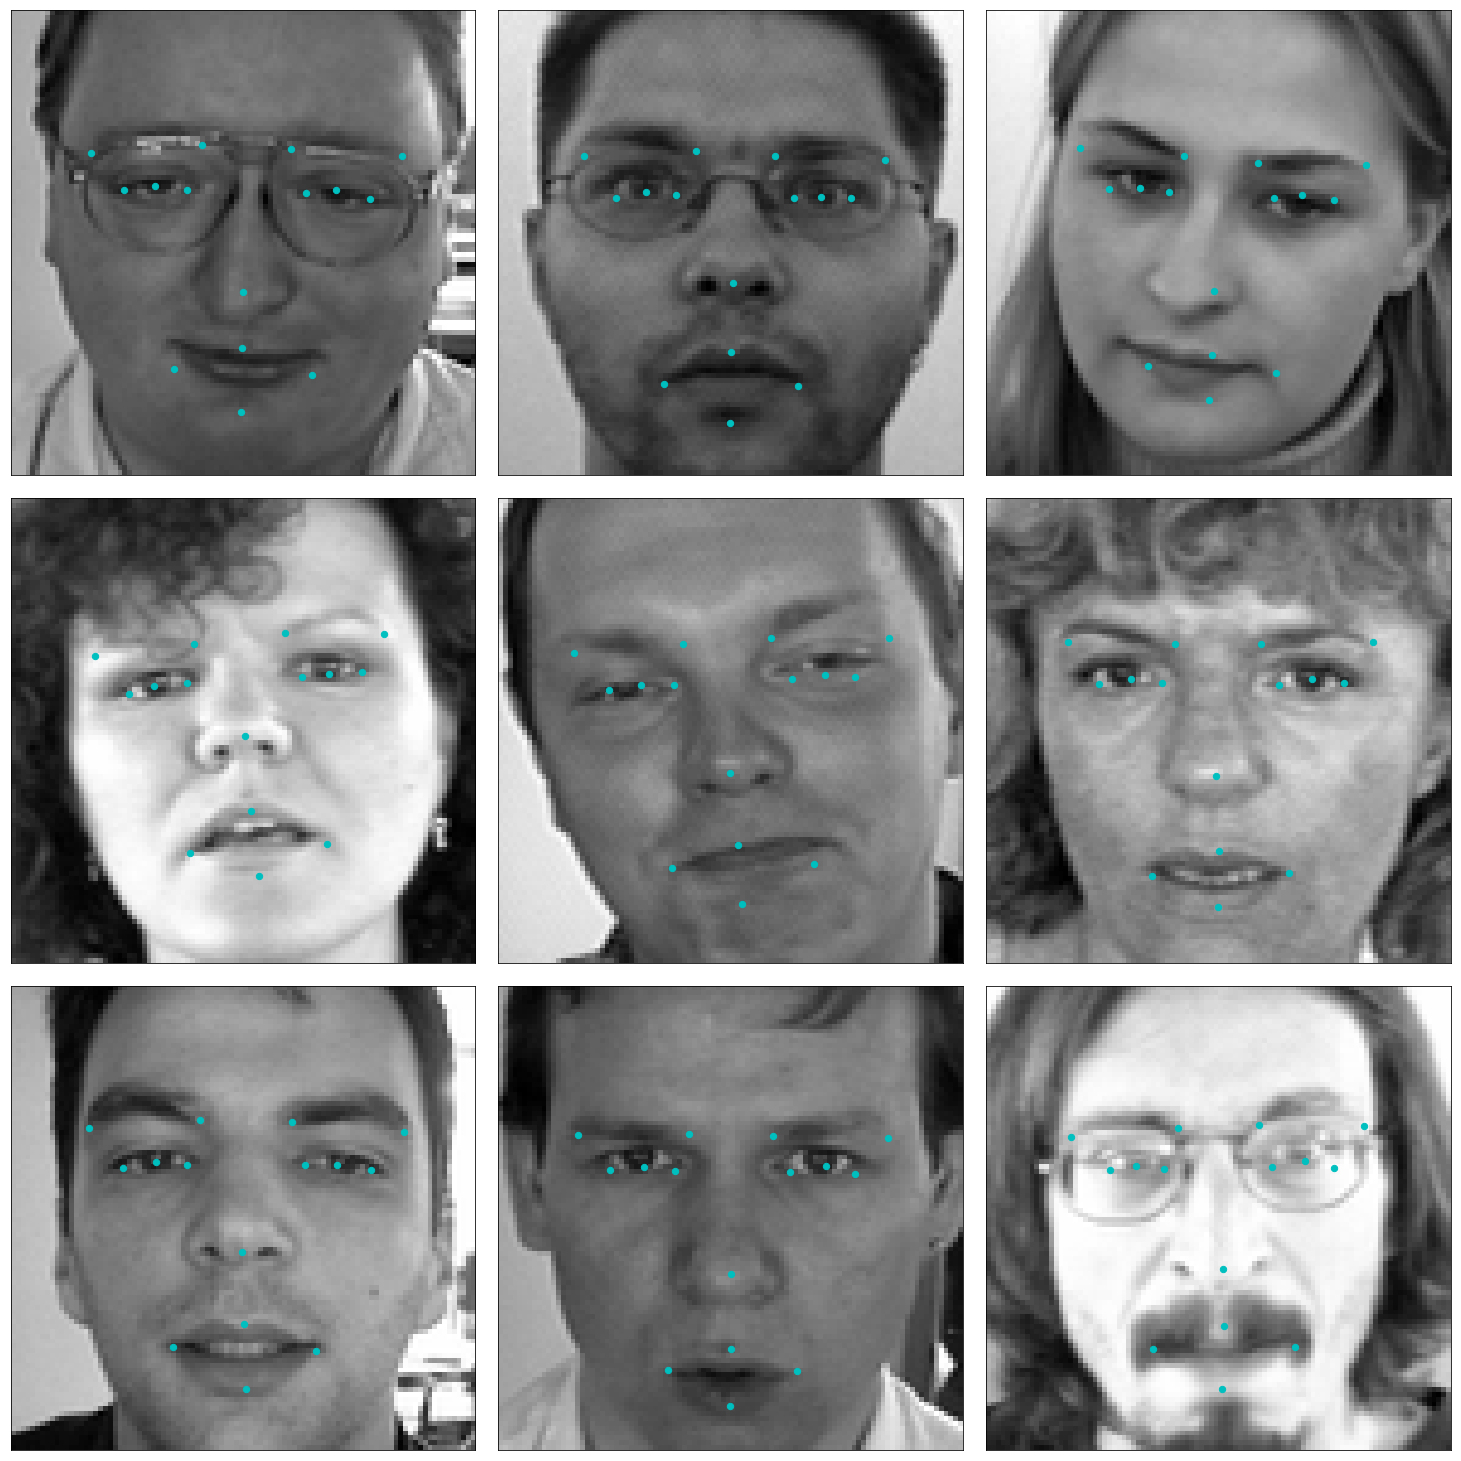

In [149]:
# predict the test set
X_test_06, y_test_pred_06 = predict_test(rst_06)
plot_samples(X_test_06,y_test_pred_06)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

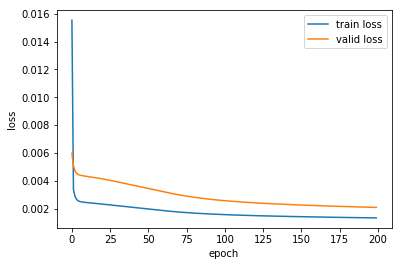

In [150]:
# print layer information
# draw loss curve
layer_info(rst_06)
draw_to_notebook(rst_06)
plot_loss(rst_06)

In [151]:
# store the results
methods.append('Feature_Engineering+modeling')
train_set_size.append(len(XX_train))
num_epoch.append(200)
RMSE.append(RMSE_rst_06)

In [152]:
methods

['Baseline',
 'Regulization_with_dropout_layers',
 'Flipping',
 'Histogram_Stretching',
 'Contrast_Jittering',
 'Fill_null_value_with_predicted',
 'Replace_null_records_with_predicted',
 'Flipping+Hist+Reduction+ReplaceNaN',
 'Feature_Engineering+modeling']

In [156]:
def display_results(methods, train_set_size, num_epoch, RMSE):
    cols = ['NO.',
            'Methods_Applied', 
            'Train_Set_Size', 
            '#._Of_Epoch', 
            'RMSE', 
            'Improvement', 
            'Overfitting']  
    results_table = pd.DataFrame(columns = cols)
    results_table['NO.'] = ['0','00','01','02', '03','04','05','06','07']
    results_table['Methods_Applied'] = methods
    results_table['Train_Set_Size'] = train_set_size
    results_table['#._Of_Epoch'] = num_epoch
    results_table['RMSE'] = RMSE
    results_table['Improvement'] = ['NA', '-','+','+','=', '-','+','+','+']
    results_table['Overfitting'] = ['NO', 'YES', 'NO', 'NO', 'NO', 'YES','YES','YES','YES']
    return results_table

In [157]:
results = display_results(methods, train_set_size, num_epoch, RMSE)
results

,NO.,Methods_Applied,Train_Set_Size,#._Of_Epoch,RMSE,Improvement,Overfitting
0,0,Baseline,2140,35,3.214488,NA,NO
1,00,Regulization_with_dropout_layers,2140,35,5.290542,-,YES
2,01,Flipping,4280,35,3.194874,+,NO
3,02,Histogram_Stretching,4280,35,3.298490,+,NO
4,03,Contrast_Jittering,4280,35,3.127301,=,NO
5,04,Fill_null_value_with_predicted,7049,35,3.668562,-,YES
6,05,Replace_null_records_with_predicted,7049,35,3.214024,+,YES
7,06,Flipping+Hist+Reduction+ReplaceNaN,13469,35,2.999871,+,YES
8,07,Feature_Engineering+modeling,13469,200,2.173361,+,YES
